# Final Experiment (Pain Area Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset, get_class_names
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.CNNLSTMfusioned import CNNLSTM_fusioned
from src.models.RCNN import RCNN
from src.models.RCNNfusioned import RCNN_fusioned
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
epochs = 100

cnnlstm_auc = []
rcnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(380, 1, 350, 35) (380, 4)
(235, 1, 350, 35) (235, 4)


In [ ]:
extra_X_train, extra_X_test, extra_y_train, extra_y_test = load_dataset('skeleton', nopain=False, only_minority=True)
jitter_X = jitter(extra_X_train, sigma=0.03)
reshaped_X = extra_X_train.reshape((extra_X_train.shape[0], extra_X_train.shape[2], extra_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_y_train, extra_y_train), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

In [5]:
classes = get_class_names('skeleton', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       245
Back Region       73
Upper Body        57
Head and Neck      5
dtype: int64

In [6]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.3013698630136987, 1: 19.0, 2: 0.3877551020408163, 3: 1.6666666666666667}

### 1.1 CNN + BiLSTM

Epoch 1/100
11/11 - 20s - loss: 1.3503 - accuracy: 0.2544 - auc: 0.5873 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1792 - val_loss: 1.2513 - val_accuracy: 0.6053 - val_auc: 0.7911 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1885 - 20s/epoch - 2s/step
Epoch 2/100
11/11 - 1s - loss: 1.3068 - accuracy: 0.4942 - auc: 0.7741 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.3713 - val_loss: 1.2557 - val_accuracy: 0.4211 - val_auc: 0.7379 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1929 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2970 - accuracy: 0.5292 - auc: 0.8040 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.3790 - val_loss: 1.3166 - val_accuracy: 0.2105 - val_auc: 0.6309 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0870 - 1s/epoch - 120ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1839 - accuracy: 0.4035 - auc: 0.7512 - precision: 0.0000e+00 - recall: 0.0000e+00 

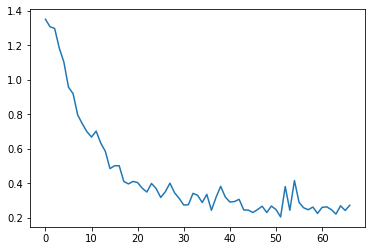

Epoch 1/100
11/11 - 9s - loss: 1.4505 - accuracy: 0.3947 - auc_1: 0.6989 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.2387 - val_loss: 1.2358 - val_accuracy: 0.6053 - val_auc_1: 0.8126 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1885 - 9s/epoch - 825ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3542 - accuracy: 0.4737 - auc_1: 0.7806 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.3897 - val_loss: 1.2626 - val_accuracy: 0.5789 - val_auc_1: 0.8032 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1833 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2733 - accuracy: 0.4444 - auc_1: 0.7283 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.3828 - val_loss: 1.1920 - val_accuracy: 0.6579 - val_auc_1: 0.8129 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2887 - 1s/epoch - 122ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2276 - accuracy: 0.5058 - auc_1: 0.7795 - prec

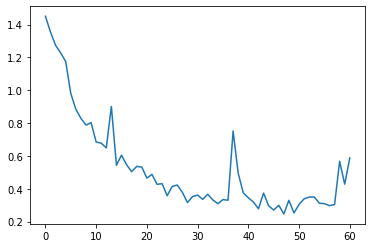

Epoch 1/100
11/11 - 8s - loss: 1.2746 - accuracy: 0.2982 - auc_2: 0.6678 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1837 - val_loss: 1.2913 - val_accuracy: 0.3684 - val_auc_2: 0.7130 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1489 - 8s/epoch - 760ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1778 - accuracy: 0.3246 - auc_2: 0.6966 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.2341 - val_loss: 1.3225 - val_accuracy: 0.6579 - val_auc_2: 0.7290 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1984 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1064 - accuracy: 0.3830 - auc_2: 0.7384 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.3564 - val_loss: 1.4044 - val_accuracy: 0.0526 - val_auc_2: 0.5323 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0250 - 1s/epoch - 120ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9957 - accuracy: 0.3830 - auc_2: 0.7436 - prec

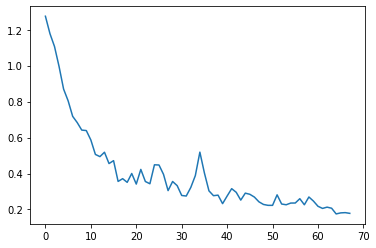

Epoch 1/100
11/11 - 9s - loss: 1.4241 - accuracy: 0.1140 - auc_3: 0.3482 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1357 - val_loss: 1.4575 - val_accuracy: 0.0000e+00 - val_auc_3: 0.3291 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.0000e+00 - 9s/epoch - 782ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3427 - accuracy: 0.3333 - auc_3: 0.6137 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.2740 - val_loss: 1.4553 - val_accuracy: 0.0000e+00 - val_auc_3: 0.4676 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.0000e+00 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2883 - accuracy: 0.3830 - auc_3: 0.6615 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.2835 - val_loss: 1.4437 - val_accuracy: 0.0000e+00 - val_auc_3: 0.4507 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.0000e+00 - 1s/epoch - 123ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1165 - accuracy: 0.424

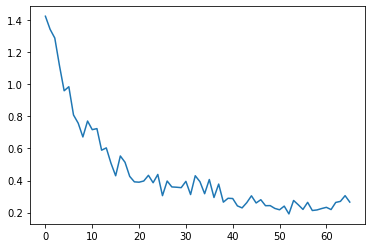

Epoch 1/100
11/11 - 9s - loss: 1.4612 - accuracy: 0.2018 - auc_4: 0.4522 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.1444 - val_loss: 1.3166 - val_accuracy: 0.2368 - val_auc_4: 0.7076 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0957 - 9s/epoch - 795ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3695 - accuracy: 0.2632 - auc_4: 0.6262 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.2716 - val_loss: 1.2772 - val_accuracy: 0.7105 - val_auc_4: 0.8815 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.2077 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2778 - accuracy: 0.3070 - auc_4: 0.6606 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.3477 - val_loss: 1.2181 - val_accuracy: 0.7105 - val_auc_4: 0.8750 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.2077 - 1s/epoch - 121ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1625 - accuracy: 0.3860 - auc_4: 0.6954 - prec

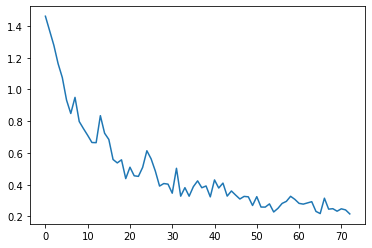

Epoch 1/100
11/11 - 8s - loss: 1.4125 - accuracy: 0.1813 - auc_5: 0.4611 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1236 - val_loss: 1.3724 - val_accuracy: 0.3421 - val_auc_5: 0.6326 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1851 - 8s/epoch - 770ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3290 - accuracy: 0.5556 - auc_5: 0.7721 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.3940 - val_loss: 1.3903 - val_accuracy: 0.0789 - val_auc_5: 0.4192 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0652 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2233 - accuracy: 0.4474 - auc_5: 0.7697 - precision_5: 1.0000 - recall_5: 0.0029 - f1_score: 0.3583 - val_loss: 1.4621 - val_accuracy: 0.0000e+00 - val_auc_5: 0.3662 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0000e+00 - 1s/epoch - 121ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0840 - accuracy: 0.3421 - auc_5: 0.6974 - prec

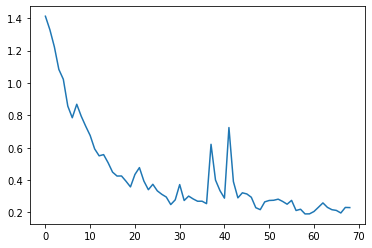

Epoch 1/100
11/11 - 8s - loss: 1.4231 - accuracy: 0.3012 - auc_6: 0.5786 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.1621 - val_loss: 1.3403 - val_accuracy: 0.1579 - val_auc_6: 0.5622 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0682 - 8s/epoch - 769ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3865 - accuracy: 0.3304 - auc_6: 0.6663 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.2407 - val_loss: 1.3656 - val_accuracy: 0.1579 - val_auc_6: 0.5313 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0682 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2725 - accuracy: 0.5409 - auc_6: 0.7840 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.4275 - val_loss: 1.3546 - val_accuracy: 0.1842 - val_auc_6: 0.5230 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.1135 - 1s/epoch - 121ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2036 - accuracy: 0.4561 - auc_6: 0.7409 - prec

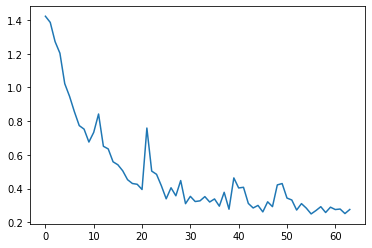

Epoch 1/100
11/11 - 8s - loss: 1.4302 - accuracy: 0.1901 - auc_7: 0.5632 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.1180 - val_loss: 1.3893 - val_accuracy: 0.2105 - val_auc_7: 0.6025 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.0870 - 8s/epoch - 721ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3769 - accuracy: 0.4327 - auc_7: 0.7310 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.3222 - val_loss: 1.4235 - val_accuracy: 0.0263 - val_auc_7: 0.3762 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.0200 - 1s/epoch - 108ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2931 - accuracy: 0.4152 - auc_7: 0.7433 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.3606 - val_loss: 1.4781 - val_accuracy: 0.0000e+00 - val_auc_7: 0.3804 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.0000e+00 - 1s/epoch - 109ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1695 - accuracy: 0.4971 - auc_7: 0.787

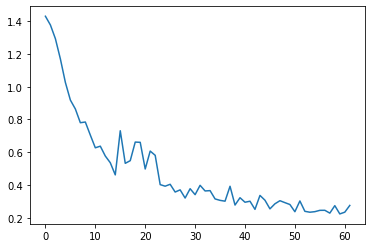

Epoch 1/100
11/11 - 8s - loss: 1.4767 - accuracy: 0.2661 - auc_8: 0.5472 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - f1_score: 0.1910 - val_loss: 1.3889 - val_accuracy: 0.0263 - val_auc_8: 0.5330 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.0161 - 8s/epoch - 718ms/step
Epoch 2/100
11/11 - 1s - loss: 1.4093 - accuracy: 0.2602 - auc_8: 0.5797 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - f1_score: 0.2220 - val_loss: 1.3316 - val_accuracy: 0.0789 - val_auc_8: 0.6105 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.0418 - 1s/epoch - 110ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3500 - accuracy: 0.3392 - auc_8: 0.6868 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - f1_score: 0.3316 - val_loss: 1.3606 - val_accuracy: 0.0526 - val_auc_8: 0.5847 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.0250 - 1s/epoch - 108ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2000 - accuracy: 0.3070 - auc_8: 0.6386 - prec

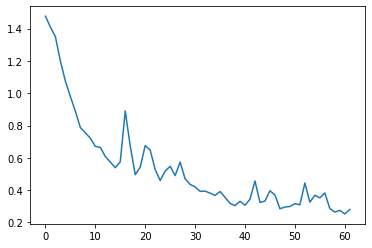

Epoch 1/100
11/11 - 8s - loss: 1.2763 - accuracy: 0.3743 - auc_9: 0.6857 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.2425 - val_loss: 1.2401 - val_accuracy: 0.6842 - val_auc_9: 0.7822 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.2031 - 8s/epoch - 717ms/step
Epoch 2/100
11/11 - 1s - loss: 1.2108 - accuracy: 0.4561 - auc_9: 0.7551 - precision_9: 1.0000 - recall_9: 0.0029 - f1_score: 0.4267 - val_loss: 1.2606 - val_accuracy: 0.3947 - val_auc_9: 0.7139 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.1663 - 1s/epoch - 109ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0958 - accuracy: 0.4825 - auc_9: 0.7667 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.4557 - val_loss: 1.2519 - val_accuracy: 0.1579 - val_auc_9: 0.6148 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.0682 - 1s/epoch - 109ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0195 - accuracy: 0.4942 - auc_9: 0.7812 - precision_9:

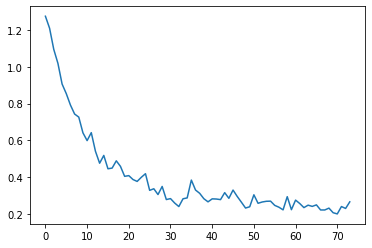

In [7]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_area_body_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_body_model.save(model_path / 'body_area_cnnlstm.h5')

#### Training performance and variance

In [8]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.8497075974941254,
 'ROC/AUC': 0.9771864593029023,
 'Precision': 0.8556913733482361,
 'Recall': 0.8435672521591187,
 'F1-score': 0.7842129588127136}

In [9]:
body_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_cnnlstm_train_var

{'Accuracy': 0.0012229403404258577,
 'ROC/AUC': 9.186134545021929e-05,
 'Precision': 0.0008116680895710715,
 'Recall': 0.0015444919718206052,
 'F1-score': 0.0017642593910358075}

#### Validation performance and variance

In [10]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.5131578922271729,
 'ROC/AUC': 0.7475646138191223,
 'Precision': 0.5184538245201111,
 'Recall': 0.5000000029802323,
 'F1-score': 0.3122346431016922}

In [11]:
body_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_cnnlstm_val_var

{'Accuracy': 0.006405815828870445,
 'ROC/AUC': 0.004086403710179098,
 'Precision': 0.005407299566767989,
 'Recall': 0.005678669385963077,
 'F1-score': 0.004846587510171476}

#### Predictions and performance on test set

In [12]:
cnnlstm_area_body_model = load_model(model_path / 'body_area_cnnlstm.h5')
y_pred = cnnlstm_area_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 32ms/step - loss: 1.1406 - accuracy: 0.4723 - auc_6: 0.7555 - precision_6: 0.4720 - recall_6: 0.2511 - f1_score: 0.2101
Accuracy: 47.23% 
Balanced Accuracy: 24.23% 
ROC/AUC: 0.76 
Precision: 0.47 
Recall: 0.25 
F1 score: 0.21


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

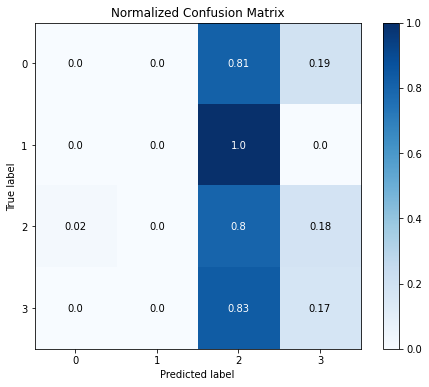

In [13]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

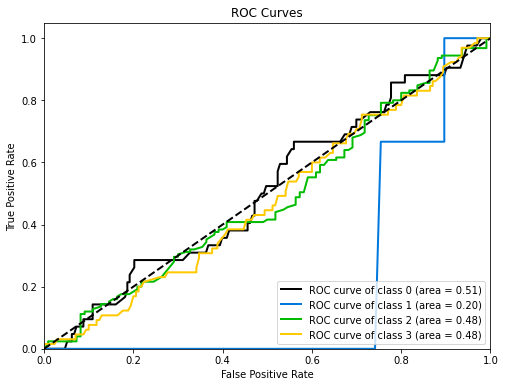

In [14]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

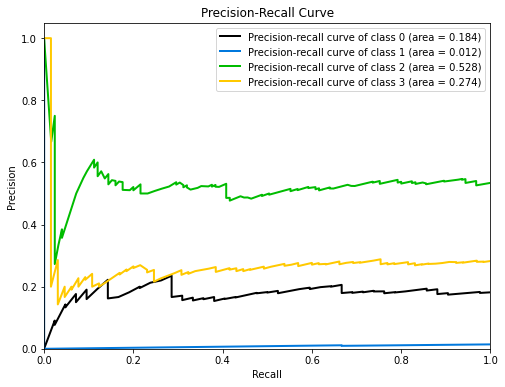

In [15]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

### 1.2 RCNN

Epoch 1/100
11/11 - 3s - loss: 2.0297 - accuracy: 0.2924 - auc_10: 0.5425 - precision_10: 0.2773 - recall_10: 0.1784 - f1_score: 0.2268 - val_loss: 8.7679 - val_accuracy: 0.6053 - val_auc_10: 0.7334 - val_precision_10: 0.6053 - val_recall_10: 0.6053 - val_f1_score: 0.1885 - 3s/epoch - 231ms/step
Epoch 2/100
11/11 - 0s - loss: 1.2823 - accuracy: 0.3830 - auc_10: 0.6675 - precision_10: 0.3798 - recall_10: 0.2310 - f1_score: 0.2914 - val_loss: 7.5682 - val_accuracy: 0.6053 - val_auc_10: 0.7368 - val_precision_10: 0.6053 - val_recall_10: 0.6053 - val_f1_score: 0.1885 - 306ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0260 - accuracy: 0.4620 - auc_10: 0.7604 - precision_10: 0.4922 - recall_10: 0.3713 - f1_score: 0.3700 - val_loss: 9.8401 - val_accuracy: 0.1316 - val_auc_10: 0.4182 - val_precision_10: 0.1316 - val_recall_10: 0.1316 - val_f1_score: 0.0982 - 288ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9557 - accuracy: 0.5029 - auc_10: 0.7645 - precision_10: 0.4906 - recall

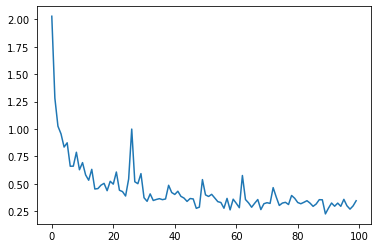

Epoch 1/100
11/11 - 3s - loss: 1.9679 - accuracy: 0.2632 - auc_11: 0.5813 - precision_11: 0.2411 - recall_11: 0.1579 - f1_score: 0.2119 - val_loss: 8.1100 - val_accuracy: 0.2632 - val_auc_11: 0.4551 - val_precision_11: 0.2632 - val_recall_11: 0.2632 - val_f1_score: 0.1740 - 3s/epoch - 258ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1481 - accuracy: 0.3684 - auc_11: 0.6958 - precision_11: 0.3766 - recall_11: 0.2544 - f1_score: 0.3199 - val_loss: 7.6297 - val_accuracy: 0.2105 - val_auc_11: 0.4815 - val_precision_11: 0.2105 - val_recall_11: 0.2105 - val_f1_score: 0.0870 - 288ms/epoch - 26ms/step
Epoch 3/100
11/11 - 0s - loss: 1.2511 - accuracy: 0.4006 - auc_11: 0.6952 - precision_11: 0.3955 - recall_11: 0.3099 - f1_score: 0.3304 - val_loss: 2.9002 - val_accuracy: 0.4737 - val_auc_11: 0.7456 - val_precision_11: 0.4737 - val_recall_11: 0.4737 - val_f1_score: 0.2292 - 286ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9708 - accuracy: 0.5263 - auc_11: 0.7915 - precision_11: 0.5647 - recall

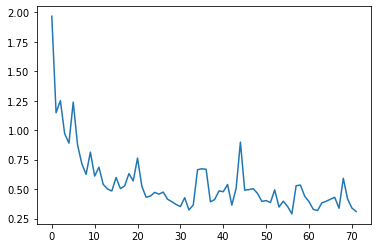

Epoch 1/100
11/11 - 3s - loss: 2.4658 - accuracy: 0.2982 - auc_12: 0.6251 - precision_12: 0.3176 - recall_12: 0.2368 - f1_score: 0.2045 - val_loss: 32.1645 - val_accuracy: 0.0526 - val_auc_12: 0.3684 - val_precision_12: 0.0526 - val_recall_12: 0.0526 - val_f1_score: 0.0250 - 3s/epoch - 228ms/step
Epoch 2/100
11/11 - 0s - loss: 1.2108 - accuracy: 0.4064 - auc_12: 0.6664 - precision_12: 0.3956 - recall_12: 0.2602 - f1_score: 0.3202 - val_loss: 7.2274 - val_accuracy: 0.1579 - val_auc_12: 0.3696 - val_precision_12: 0.1579 - val_recall_12: 0.1579 - val_f1_score: 0.1414 - 298ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 0.9850 - accuracy: 0.4386 - auc_12: 0.7125 - precision_12: 0.4444 - recall_12: 0.3275 - f1_score: 0.3651 - val_loss: 2.8835 - val_accuracy: 0.2895 - val_auc_12: 0.6491 - val_precision_12: 0.2703 - val_recall_12: 0.2632 - val_f1_score: 0.1585 - 293ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9740 - accuracy: 0.4591 - auc_12: 0.7426 - precision_12: 0.4630 - recal

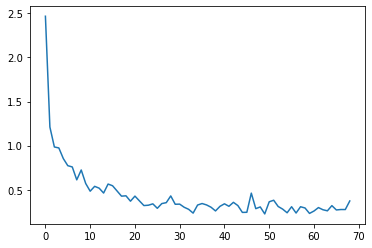

Epoch 1/100
11/11 - 2s - loss: 2.7376 - accuracy: 0.3099 - auc_13: 0.5711 - precision_13: 0.2903 - recall_13: 0.2105 - f1_score: 0.2065 - val_loss: 52.5024 - val_accuracy: 0.0000e+00 - val_auc_13: 0.3333 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.0000e+00 - 2s/epoch - 227ms/step
Epoch 2/100
11/11 - 0s - loss: 1.4845 - accuracy: 0.3538 - auc_13: 0.6376 - precision_13: 0.3484 - recall_13: 0.2251 - f1_score: 0.2687 - val_loss: 7.5994 - val_accuracy: 0.0526 - val_auc_13: 0.3491 - val_precision_13: 0.0526 - val_recall_13: 0.0526 - val_f1_score: 0.0313 - 293ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0712 - accuracy: 0.4006 - auc_13: 0.7088 - precision_13: 0.4308 - recall_13: 0.3187 - f1_score: 0.3326 - val_loss: 12.7575 - val_accuracy: 0.1579 - val_auc_13: 0.4386 - val_precision_13: 0.1579 - val_recall_13: 0.1579 - val_f1_score: 0.0682 - 281ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 1.1128 - accuracy: 0.4474 - auc_13: 0.7440 - precision_1

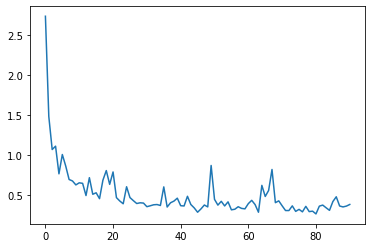

Epoch 1/100
11/11 - 3s - loss: 2.4749 - accuracy: 0.1696 - auc_14: 0.4461 - precision_14: 0.1809 - recall_14: 0.1053 - f1_score: 0.1425 - val_loss: 62.1412 - val_accuracy: 0.0526 - val_auc_14: 0.3684 - val_precision_14: 0.0526 - val_recall_14: 0.0526 - val_f1_score: 0.0250 - 3s/epoch - 250ms/step
Epoch 2/100
11/11 - 0s - loss: 1.3841 - accuracy: 0.3158 - auc_14: 0.6050 - precision_14: 0.3378 - recall_14: 0.2222 - f1_score: 0.2736 - val_loss: 27.9107 - val_accuracy: 0.2368 - val_auc_14: 0.4912 - val_precision_14: 0.2368 - val_recall_14: 0.2368 - val_f1_score: 0.0957 - 299ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.3459 - accuracy: 0.3480 - auc_14: 0.6595 - precision_14: 0.3548 - recall_14: 0.2895 - f1_score: 0.3062 - val_loss: 5.8509 - val_accuracy: 0.6316 - val_auc_14: 0.7657 - val_precision_14: 0.6316 - val_recall_14: 0.6316 - val_f1_score: 0.2000 - 288ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9871 - accuracy: 0.4269 - auc_14: 0.7353 - precision_14: 0.4602 - reca

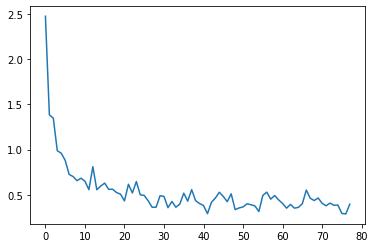

Epoch 1/100
11/11 - 2s - loss: 2.4966 - accuracy: 0.3070 - auc_15: 0.5663 - precision_15: 0.3042 - recall_15: 0.2339 - f1_score: 0.2232 - val_loss: 16.7915 - val_accuracy: 0.0000e+00 - val_auc_15: 0.3246 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0000e+00 - 2s/epoch - 223ms/step
Epoch 2/100
11/11 - 0s - loss: 1.3739 - accuracy: 0.3947 - auc_15: 0.6142 - precision_15: 0.3881 - recall_15: 0.2281 - f1_score: 0.3194 - val_loss: 6.8821 - val_accuracy: 0.2368 - val_auc_15: 0.4701 - val_precision_15: 0.2368 - val_recall_15: 0.2368 - val_f1_score: 0.1347 - 295ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0912 - accuracy: 0.4795 - auc_15: 0.7522 - precision_15: 0.5021 - recall_15: 0.3421 - f1_score: 0.3831 - val_loss: 11.1174 - val_accuracy: 0.1842 - val_auc_15: 0.3292 - val_precision_15: 0.1892 - val_recall_15: 0.1842 - val_f1_score: 0.1366 - 280ms/epoch - 25ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9644 - accuracy: 0.4444 - auc_15: 0.7341 - precision_1

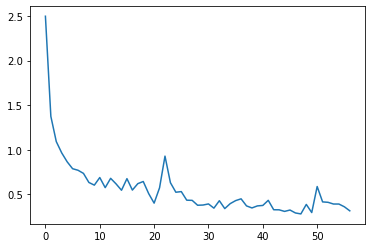

Epoch 1/100
11/11 - 3s - loss: 2.7233 - accuracy: 0.3333 - auc_16: 0.6077 - precision_16: 0.3640 - recall_16: 0.2427 - f1_score: 0.2356 - val_loss: 23.2711 - val_accuracy: 0.1579 - val_auc_16: 0.4488 - val_precision_16: 0.1579 - val_recall_16: 0.1579 - val_f1_score: 0.0682 - 3s/epoch - 228ms/step
Epoch 2/100
11/11 - 0s - loss: 1.3142 - accuracy: 0.3947 - auc_16: 0.6878 - precision_16: 0.4065 - recall_16: 0.2544 - f1_score: 0.3115 - val_loss: 34.2929 - val_accuracy: 0.1579 - val_auc_16: 0.4386 - val_precision_16: 0.1579 - val_recall_16: 0.1579 - val_f1_score: 0.0682 - 284ms/epoch - 26ms/step
Epoch 3/100
11/11 - 0s - loss: 1.2902 - accuracy: 0.4269 - auc_16: 0.6960 - precision_16: 0.4737 - recall_16: 0.3421 - f1_score: 0.3252 - val_loss: 3.6709 - val_accuracy: 0.1579 - val_auc_16: 0.4004 - val_precision_16: 0.1622 - val_recall_16: 0.1579 - val_f1_score: 0.1204 - 288ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9625 - accuracy: 0.4678 - auc_16: 0.7486 - precision_16: 0.4922 - reca

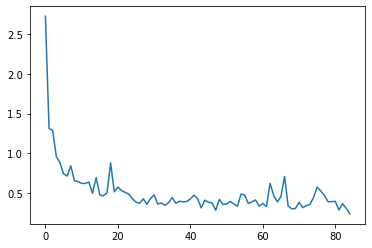

Epoch 1/100
11/11 - 3s - loss: 2.6593 - accuracy: 0.2865 - auc_17: 0.5761 - precision_17: 0.2955 - recall_17: 0.2135 - f1_score: 0.2128 - val_loss: 73.3386 - val_accuracy: 0.0000e+00 - val_auc_17: 0.3333 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 249ms/step
Epoch 2/100
11/11 - 0s - loss: 1.2410 - accuracy: 0.3421 - auc_17: 0.6517 - precision_17: 0.3514 - recall_17: 0.2281 - f1_score: 0.2887 - val_loss: 25.7878 - val_accuracy: 0.2105 - val_auc_17: 0.4737 - val_precision_17: 0.2105 - val_recall_17: 0.2105 - val_f1_score: 0.0870 - 300ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.2391 - accuracy: 0.3860 - auc_17: 0.6980 - precision_17: 0.3881 - recall_17: 0.3041 - f1_score: 0.3302 - val_loss: 5.4607 - val_accuracy: 0.2105 - val_auc_17: 0.5779 - val_precision_17: 0.2105 - val_recall_17: 0.2105 - val_f1_score: 0.0870 - 298ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9710 - accuracy: 0.4766 - auc_17: 0.7781 - precision_1

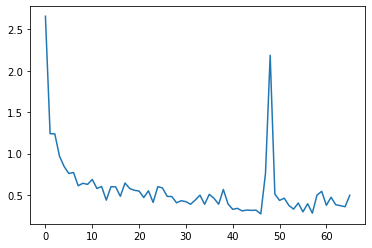

Epoch 1/100
11/11 - 2s - loss: 2.5063 - accuracy: 0.2251 - auc_18: 0.4877 - precision_18: 0.2110 - recall_18: 0.1345 - f1_score: 0.1953 - val_loss: 15.9098 - val_accuracy: 0.1579 - val_auc_18: 0.4386 - val_precision_18: 0.1579 - val_recall_18: 0.1579 - val_f1_score: 0.0682 - 2s/epoch - 223ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1164 - accuracy: 0.3977 - auc_18: 0.6895 - precision_18: 0.4233 - recall_18: 0.2661 - f1_score: 0.3518 - val_loss: 1.4915 - val_accuracy: 0.5000 - val_auc_18: 0.7779 - val_precision_18: 0.5143 - val_recall_18: 0.4737 - val_f1_score: 0.2721 - 292ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0736 - accuracy: 0.3977 - auc_18: 0.7265 - precision_18: 0.4335 - recall_18: 0.2953 - f1_score: 0.3865 - val_loss: 12.6648 - val_accuracy: 0.0526 - val_auc_18: 0.4054 - val_precision_18: 0.0526 - val_recall_18: 0.0526 - val_f1_score: 0.0250 - 289ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 1.0466 - accuracy: 0.5000 - auc_18: 0.7615 - precision_18: 0.5240 - reca

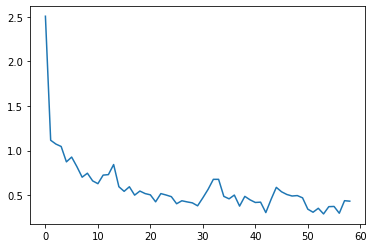

Epoch 1/100
11/11 - 2s - loss: 2.2321 - accuracy: 0.2895 - auc_19: 0.6028 - precision_19: 0.2961 - recall_19: 0.2018 - f1_score: 0.2150 - val_loss: 3.4268 - val_accuracy: 0.3158 - val_auc_19: 0.6509 - val_precision_19: 0.3158 - val_recall_19: 0.3158 - val_f1_score: 0.1724 - 2s/epoch - 222ms/step
Epoch 2/100
11/11 - 0s - loss: 1.2223 - accuracy: 0.3596 - auc_19: 0.6738 - precision_19: 0.3871 - recall_19: 0.2807 - f1_score: 0.2901 - val_loss: 19.0810 - val_accuracy: 0.1053 - val_auc_19: 0.4035 - val_precision_19: 0.1053 - val_recall_19: 0.1053 - val_f1_score: 0.0476 - 276ms/epoch - 25ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0047 - accuracy: 0.4678 - auc_19: 0.7427 - precision_19: 0.4982 - recall_19: 0.3947 - f1_score: 0.4302 - val_loss: 3.2648 - val_accuracy: 0.6842 - val_auc_19: 0.7619 - val_precision_19: 0.6842 - val_recall_19: 0.6842 - val_f1_score: 0.2031 - 295ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 1.1331 - accuracy: 0.4795 - auc_19: 0.7859 - precision_19: 0.5017 - recal

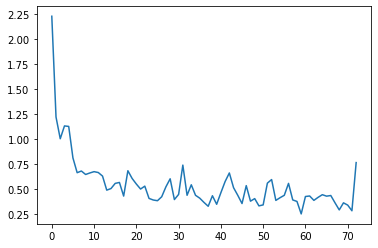

In [16]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_area_body_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_area_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_body_model.save(model_path / 'body_area_rcnn.h5')

#### Training performance and variance

In [17]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.8663742661476135,
 'ROC/AUC': 0.964175420999527,
 'Precision': 0.8702050268650054,
 'Recall': 0.8628654897212982,
 'F1-score': 0.7946032822132111}

In [18]:
body_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_rcnn_train_var

{'Accuracy': 0.00021211642222013438,
 'ROC/AUC': 5.6123796634501846e-05,
 'Precision': 0.00017443012242498667,
 'Recall': 0.00025896850937602524,
 'F1-score': 0.0005536982862910022}

#### Validation performance and variance

In [19]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.5289473682641983,
 'ROC/AUC': 0.7691251039505005,
 'Precision': 0.5466493546962738,
 'Recall': 0.5236842125654221,
 'F1-score': 0.31189611554145813}

In [20]:
body_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_rcnn_val_var

{'Accuracy': 0.003663433822403528,
 'ROC/AUC': 0.002826118630553509,
 'Precision': 0.004457861043634672,
 'Recall': 0.0032479221429522294,
 'F1-score': 0.0027077562191534454}

#### Predictions and performance on test set

In [21]:
rcnn_area_body_model = load_model(model_path / 'body_area_rcnn.h5')
y_pred = rcnn_area_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 9ms/step - loss: 1.7469 - accuracy: 0.3830 - auc_16: 0.6806 - precision_16: 0.3835 - recall_16: 0.3362 - f1_score: 0.2201
Accuracy: 38.30% 
Balanced Accuracy: 23.27% 
ROC/AUC: 0.68 
Precision: 0.38 
Recall: 0.34 
F1 score: 0.22


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

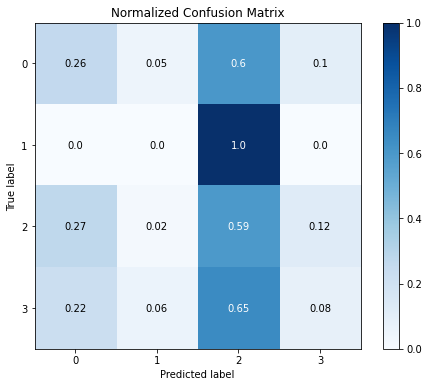

In [22]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

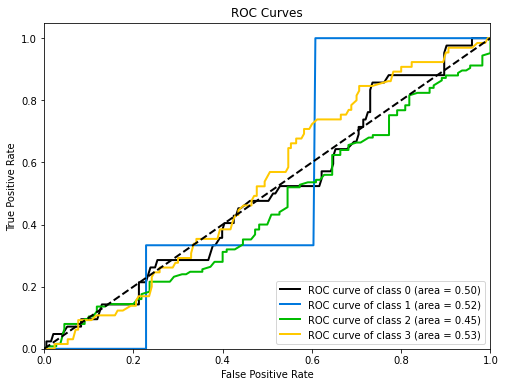

In [23]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

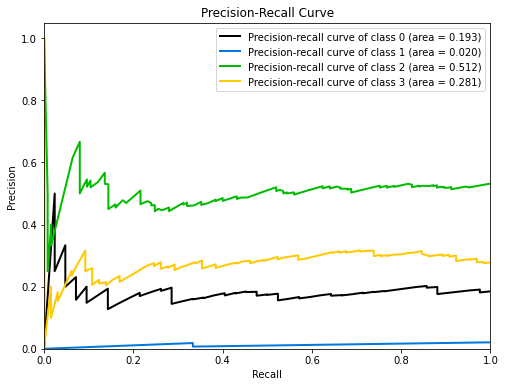

In [25]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

## 2. Unimodal Face (Facial Expression + Head Pose)

In [26]:
X_train, X_test, y_train, y_test = load_dataset('AUs', nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 25) (366, 4)
(231, 1, 350, 25) (231, 4)


In [27]:
classes = get_class_names('AUs', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       236
Back Region       69
Upper Body        57
Head and Neck      4
dtype: int64

In [28]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.326086956521739, 1: 22.875, 2: 0.3877118644067797, 3: 1.605263157894737}

### 2.1 CNN + BiLSTM

Epoch 1/100
11/11 - 9s - loss: 1.4268 - accuracy: 0.3799 - auc_20: 0.6809 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.2012 - val_loss: 1.3672 - val_accuracy: 0.1892 - val_auc_20: 0.5463 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1346 - 9s/epoch - 782ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3960 - accuracy: 0.2705 - auc_20: 0.5941 - precision_20: 0.7500 - recall_20: 0.0091 - f1_score: 0.1934 - val_loss: 1.3661 - val_accuracy: 0.2432 - val_auc_20: 0.6395 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1430 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3817 - accuracy: 0.3009 - auc_20: 0.6646 - precision_20: 0.7500 - recall_20: 0.0182 - f1_score: 0.2197 - val_loss: 1.3600 - val_accuracy: 0.2432 - val_auc_20: 0.6290 - val_precision_20: 1.0000 - val_recall_20: 0.0270 - val_f1_score: 0.1452 - 1s/epoch - 121ms/step
Epoch 4/100
11/11 - 1s - loss: 1.4034 - accuracy: 0.3708 - auc_20: 0.6848 - precision

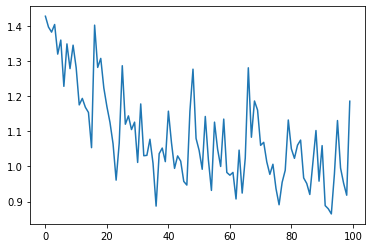

Epoch 1/100
11/11 - 8s - loss: 1.4353 - accuracy: 0.4195 - auc_21: 0.6585 - precision_21: 0.0000e+00 - recall_21: 0.0000e+00 - f1_score: 0.2009 - val_loss: 1.3676 - val_accuracy: 0.5135 - val_auc_21: 0.7082 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - val_f1_score: 0.2492 - 8s/epoch - 757ms/step
Epoch 2/100
11/11 - 1s - loss: 1.4078 - accuracy: 0.5410 - auc_21: 0.7655 - precision_21: 0.0000e+00 - recall_21: 0.0000e+00 - f1_score: 0.2393 - val_loss: 1.3686 - val_accuracy: 0.4054 - val_auc_21: 0.6766 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - val_f1_score: 0.2144 - 1s/epoch - 120ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3727 - accuracy: 0.3191 - auc_21: 0.6375 - precision_21: 0.8000 - recall_21: 0.0122 - f1_score: 0.1999 - val_loss: 1.3675 - val_accuracy: 0.3784 - val_auc_21: 0.6112 - val_precision_21: 0.5000 - val_recall_21: 0.0270 - val_f1_score: 0.2546 - 1s/epoch - 121ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3766 - accuracy: 0.3070 - auc_21: 0.6619 - p

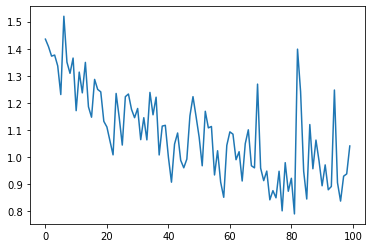

Epoch 1/100
11/11 - 9s - loss: 1.3623 - accuracy: 0.3070 - auc_22: 0.6705 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - f1_score: 0.1977 - val_loss: 1.3505 - val_accuracy: 0.1351 - val_auc_22: 0.6159 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.0595 - 9s/epoch - 845ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3284 - accuracy: 0.4103 - auc_22: 0.7165 - precision_22: 1.0000 - recall_22: 0.0091 - f1_score: 0.2653 - val_loss: 1.3469 - val_accuracy: 0.1622 - val_auc_22: 0.6318 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.0810 - 1s/epoch - 120ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2701 - accuracy: 0.4681 - auc_22: 0.7530 - precision_22: 0.7000 - recall_22: 0.0213 - f1_score: 0.3177 - val_loss: 1.3455 - val_accuracy: 0.2162 - val_auc_22: 0.6326 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.1193 - 1s/epoch - 123ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2594 - accuracy: 0.3799 - auc_22: 0.7073 - p

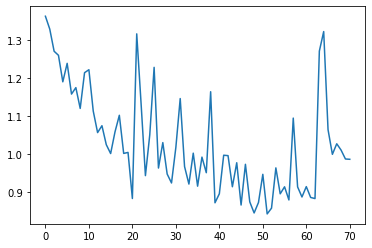

Epoch 1/100
11/11 - 8s - loss: 1.4311 - accuracy: 0.2432 - auc_23: 0.5830 - precision_23: 1.0000 - recall_23: 0.0030 - f1_score: 0.1876 - val_loss: 1.3660 - val_accuracy: 0.2432 - val_auc_23: 0.5892 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - val_f1_score: 0.1667 - 8s/epoch - 733ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3967 - accuracy: 0.3951 - auc_23: 0.6775 - precision_23: 0.8000 - recall_23: 0.0122 - f1_score: 0.2547 - val_loss: 1.3739 - val_accuracy: 0.2162 - val_auc_23: 0.6343 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - val_f1_score: 0.1189 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3817 - accuracy: 0.4802 - auc_23: 0.7384 - precision_23: 0.7778 - recall_23: 0.0213 - f1_score: 0.2803 - val_loss: 1.3754 - val_accuracy: 0.5405 - val_auc_23: 0.6657 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - val_f1_score: 0.2746 - 1s/epoch - 121ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3819 - accuracy: 0.4681 - auc_23: 0.7244 - precision

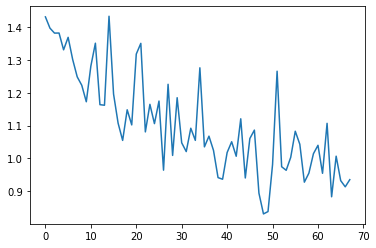

Epoch 1/100
11/11 - 8s - loss: 1.4383 - accuracy: 0.2675 - auc_24: 0.5951 - precision_24: 1.0000 - recall_24: 0.0030 - f1_score: 0.1882 - val_loss: 1.3906 - val_accuracy: 0.1081 - val_auc_24: 0.5089 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score: 0.0580 - 8s/epoch - 737ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3986 - accuracy: 0.3435 - auc_24: 0.5893 - precision_24: 0.8571 - recall_24: 0.0182 - f1_score: 0.2685 - val_loss: 1.4015 - val_accuracy: 0.2162 - val_auc_24: 0.4679 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score: 0.1205 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3865 - accuracy: 0.3799 - auc_24: 0.6763 - precision_24: 0.8750 - recall_24: 0.0213 - f1_score: 0.2495 - val_loss: 1.4021 - val_accuracy: 0.5135 - val_auc_24: 0.6434 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score: 0.2221 - 1s/epoch - 120ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3760 - accuracy: 0.4286 - auc_24: 0.7041 - precision

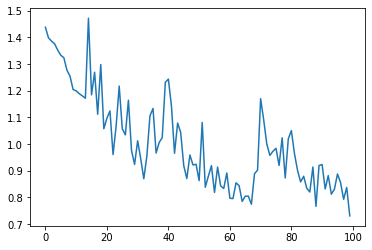

Epoch 1/100
11/11 - 8s - loss: 1.4400 - accuracy: 0.4225 - auc_25: 0.6911 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - f1_score: 0.2361 - val_loss: 1.3682 - val_accuracy: 0.0541 - val_auc_25: 0.5928 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_f1_score: 0.0256 - 8s/epoch - 719ms/step
Epoch 2/100
11/11 - 1s - loss: 1.4421 - accuracy: 0.2158 - auc_25: 0.6412 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - f1_score: 0.1440 - val_loss: 1.3661 - val_accuracy: 0.0541 - val_auc_25: 0.5997 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_f1_score: 0.0256 - 1s/epoch - 109ms/step
Epoch 3/100
11/11 - 1s - loss: 1.4228 - accuracy: 0.2979 - auc_25: 0.6786 - precision_25: 0.8000 - recall_25: 0.0122 - f1_score: 0.1964 - val_loss: 1.3748 - val_accuracy: 0.1892 - val_auc_25: 0.5102 - val_precision_25: 1.0000 - val_recall_25: 0.0270 - val_f1_score: 0.1044 - 1s/epoch - 108ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3960 - accuracy: 0.4438 - auc_25: 0.7137 - p

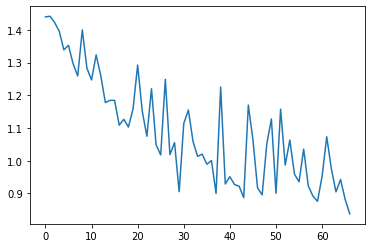

Epoch 1/100
11/11 - 8s - loss: 1.4745 - accuracy: 0.2121 - auc_26: 0.5492 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - f1_score: 0.1468 - val_loss: 1.3400 - val_accuracy: 0.1389 - val_auc_26: 0.6227 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_f1_score: 0.0641 - 8s/epoch - 727ms/step
Epoch 2/100
11/11 - 1s - loss: 1.4424 - accuracy: 0.2970 - auc_26: 0.6640 - precision_26: 1.0000 - recall_26: 0.0061 - f1_score: 0.2098 - val_loss: 1.3517 - val_accuracy: 0.1389 - val_auc_26: 0.5694 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_f1_score: 0.1005 - 1s/epoch - 108ms/step
Epoch 3/100
11/11 - 1s - loss: 1.4129 - accuracy: 0.3667 - auc_26: 0.6659 - precision_26: 0.7500 - recall_26: 0.0182 - f1_score: 0.2659 - val_loss: 1.3485 - val_accuracy: 0.3333 - val_auc_26: 0.6551 - val_precision_26: 1.0000 - val_recall_26: 0.0278 - val_f1_score: 0.2236 - 1s/epoch - 109ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3704 - accuracy: 0.3818 - auc_26: 0.7180 - precision

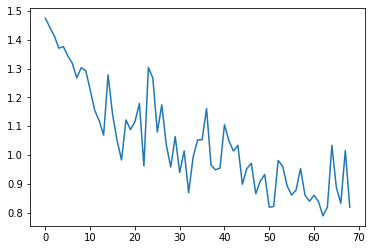

Epoch 1/100
11/11 - 8s - loss: 1.3392 - accuracy: 0.3273 - auc_27: 0.6420 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - f1_score: 0.2150 - val_loss: 1.3433 - val_accuracy: 0.6389 - val_auc_27: 0.7593 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00 - val_f1_score: 0.3032 - 8s/epoch - 720ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3071 - accuracy: 0.4121 - auc_27: 0.7381 - precision_27: 1.0000 - recall_27: 0.0061 - f1_score: 0.2668 - val_loss: 1.3181 - val_accuracy: 0.2778 - val_auc_27: 0.7119 - val_precision_27: 1.0000 - val_recall_27: 0.0556 - val_f1_score: 0.1376 - 1s/epoch - 110ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3152 - accuracy: 0.4606 - auc_27: 0.7433 - precision_27: 0.6250 - recall_27: 0.0152 - f1_score: 0.2895 - val_loss: 1.3232 - val_accuracy: 0.2222 - val_auc_27: 0.6822 - val_precision_27: 1.0000 - val_recall_27: 0.0556 - val_f1_score: 0.1943 - 1s/epoch - 108ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2555 - accuracy: 0.3394 - auc_27: 0.7339 - precision_27: 0.7

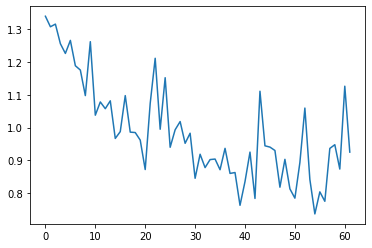

Epoch 1/100
11/11 - 8s - loss: 1.3267 - accuracy: 0.2788 - auc_28: 0.5864 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00 - f1_score: 0.1782 - val_loss: 1.3686 - val_accuracy: 0.2222 - val_auc_28: 0.6418 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00 - val_f1_score: 0.1286 - 8s/epoch - 726ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3202 - accuracy: 0.4909 - auc_28: 0.7440 - precision_28: 0.6667 - recall_28: 0.0061 - f1_score: 0.2786 - val_loss: 1.3575 - val_accuracy: 0.3889 - val_auc_28: 0.6773 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00 - val_f1_score: 0.1890 - 1s/epoch - 110ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2685 - accuracy: 0.6364 - auc_28: 0.8189 - precision_28: 0.8333 - recall_28: 0.0152 - f1_score: 0.2831 - val_loss: 1.3549 - val_accuracy: 0.2500 - val_auc_28: 0.5817 - val_precision_28: 1.0000 - val_recall_28: 0.0278 - val_f1_score: 0.1426 - 1s/epoch - 111ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2809 - accuracy: 0.5545 - auc_28: 0.7714 - precision

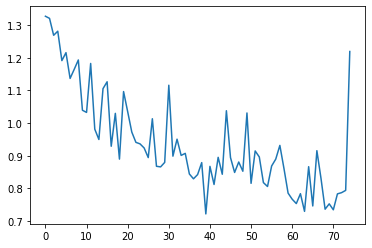

Epoch 1/100
11/11 - 8s - loss: 1.3278 - accuracy: 0.2000 - auc_29: 0.5696 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - f1_score: 0.1527 - val_loss: 1.3581 - val_accuracy: 0.1944 - val_auc_29: 0.5350 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_f1_score: 0.1604 - 8s/epoch - 718ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3103 - accuracy: 0.2818 - auc_29: 0.6769 - precision_29: 0.7500 - recall_29: 0.0182 - f1_score: 0.2089 - val_loss: 1.3649 - val_accuracy: 0.1667 - val_auc_29: 0.5179 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_f1_score: 0.1266 - 1s/epoch - 109ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2699 - accuracy: 0.3364 - auc_29: 0.7116 - precision_29: 0.7778 - recall_29: 0.0212 - f1_score: 0.2395 - val_loss: 1.3612 - val_accuracy: 0.1667 - val_auc_29: 0.5543 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_f1_score: 0.1266 - 1s/epoch - 109ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2664 - accuracy: 0.3091 - auc_29: 0.6591 - p

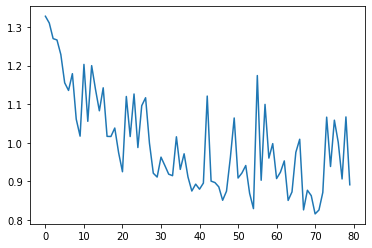

In [29]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_area_face_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_face_model.save(model_path / 'face_area_cnnlstm.h5')

#### Training performance and variance

In [30]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.4957428425550461,
 'ROC/AUC': 0.7858923435211181,
 'Precision': 0.5617261528968811,
 'Recall': 0.29869669377803804,
 'F1-score': 0.4023112654685974}

In [31]:
face_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_cnnlstm_train_var

{'Accuracy': 0.0017050943730311462,
 'ROC/AUC': 0.000999389240895141,
 'Precision': 0.0036923746369929233,
 'Recall': 0.008412240479618829,
 'F1-score': 0.0013246479986511518}

#### Validation performance and variance

In [32]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.32237237244844436,
 'ROC/AUC': 0.6510023057460785,
 'Precision': 0.26225629895925523,
 'Recall': 0.12072072084993124,
 'F1-score': 0.21547525078058244}

In [33]:
face_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_cnnlstm_val_var

{'Accuracy': 0.009012976899033734,
 'ROC/AUC': 0.004943578744532608,
 'Precision': 0.008493297739463215,
 'Recall': 0.003916281117384111,
 'F1-score': 0.00265925730568606}

#### Predictions and performance on test set

In [34]:
cnnlstm_area_face_model = load_model(model_path / 'face_area_cnnlstm.h5')
y_pred = cnnlstm_area_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_face_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 33ms/step - loss: 1.4814 - accuracy: 0.3550 - auc_24: 0.6608 - precision_24: 0.3429 - recall_24: 0.2078 - f1_score: 0.2468
Accuracy: 35.50% 
ROC/AUC: 0.66 
Precision: 0.34 
Recall: 0.21 
F1 score: 0.25


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

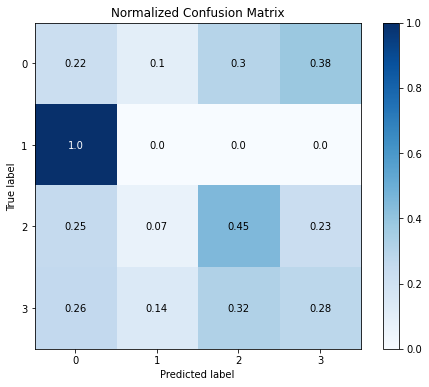

In [35]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

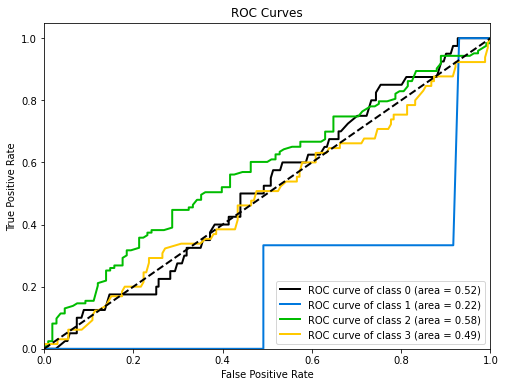

In [36]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

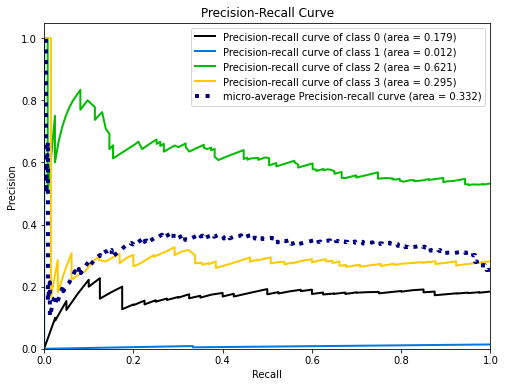

In [37]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

### 2.2 RCNN

Epoch 1/100
11/11 - 3s - loss: 2.4078 - accuracy: 0.2918 - auc_30: 0.5409 - precision_30: 0.3109 - recall_30: 0.1125 - f1_score: 0.1999 - val_loss: 1.3480 - val_accuracy: 0.2432 - val_auc_30: 0.5425 - val_precision_30: 1.0000 - val_recall_30: 0.0270 - val_f1_score: 0.1534 - 3s/epoch - 229ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5817 - accuracy: 0.2979 - auc_30: 0.5097 - precision_30: 0.3378 - recall_30: 0.0760 - f1_score: 0.2614 - val_loss: 1.2878 - val_accuracy: 0.6216 - val_auc_30: 0.8210 - val_precision_30: 1.0000 - val_recall_30: 0.0270 - val_f1_score: 0.2522 - 297ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.7166 - accuracy: 0.4590 - auc_30: 0.6355 - precision_30: 0.3846 - recall_30: 0.0912 - f1_score: 0.2344 - val_loss: 1.3514 - val_accuracy: 0.1892 - val_auc_30: 0.6669 - val_precision_30: 1.0000 - val_recall_30: 0.0270 - val_f1_score: 0.0795 - 283ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6140 - accuracy: 0.1185 - auc_30: 0.5142 - precision_30: 0.2391 - recall

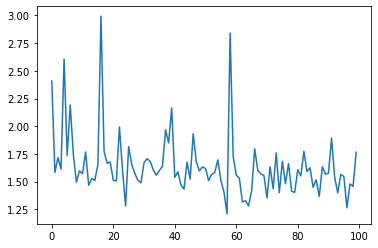

Epoch 1/100
11/11 - 2s - loss: 2.1681 - accuracy: 0.2036 - auc_31: 0.5011 - precision_31: 0.2421 - recall_31: 0.0699 - f1_score: 0.1704 - val_loss: 2.3845 - val_accuracy: 0.2162 - val_auc_31: 0.2796 - val_precision_31: 0.5000 - val_recall_31: 0.0270 - val_f1_score: 0.1439 - 2s/epoch - 227ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5787 - accuracy: 0.2614 - auc_31: 0.4910 - precision_31: 0.1857 - recall_31: 0.0395 - f1_score: 0.2179 - val_loss: 2.2229 - val_accuracy: 0.2162 - val_auc_31: 0.6706 - val_precision_31: 0.5000 - val_recall_31: 0.0270 - val_f1_score: 0.0889 - 282ms/epoch - 26ms/step
Epoch 3/100
11/11 - 0s - loss: 1.6322 - accuracy: 0.3465 - auc_31: 0.6075 - precision_31: 0.5870 - recall_31: 0.0821 - f1_score: 0.2337 - val_loss: 1.5184 - val_accuracy: 0.2162 - val_auc_31: 0.3355 - val_precision_31: 0.5000 - val_recall_31: 0.0270 - val_f1_score: 0.1439 - 287ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6853 - accuracy: 0.1337 - auc_31: 0.4444 - precision_31: 0.1524 - recall

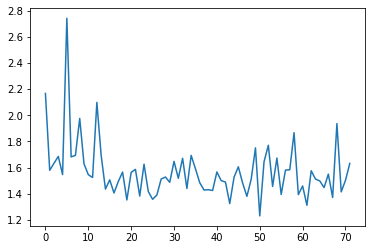

Epoch 1/100
11/11 - 3s - loss: 1.7554 - accuracy: 0.3313 - auc_32: 0.5988 - precision_32: 0.2308 - recall_32: 0.0638 - f1_score: 0.2292 - val_loss: 1.5131 - val_accuracy: 0.1622 - val_auc_32: 0.4755 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.0698 - 3s/epoch - 247ms/step
Epoch 2/100
11/11 - 0s - loss: 1.7281 - accuracy: 0.3131 - auc_32: 0.6110 - precision_32: 0.3611 - recall_32: 0.0790 - f1_score: 0.2317 - val_loss: 1.4380 - val_accuracy: 0.1351 - val_auc_32: 0.3944 - val_precision_32: 0.5000 - val_recall_32: 0.0270 - val_f1_score: 0.0685 - 280ms/epoch - 25ms/step
Epoch 3/100
11/11 - 0s - loss: 1.7444 - accuracy: 0.2067 - auc_32: 0.5166 - precision_32: 0.3398 - recall_32: 0.1064 - f1_score: 0.1791 - val_loss: 1.4985 - val_accuracy: 0.0541 - val_auc_32: 0.5388 - val_precision_32: 0.5000 - val_recall_32: 0.0270 - val_f1_score: 0.0324 - 269ms/epoch - 24ms/step
Epoch 4/100
11/11 - 0s - loss: 1.4968 - accuracy: 0.2097 - auc_32: 0.5363 - precision_32: 0.2838 

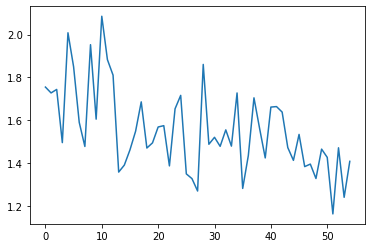

Epoch 1/100
11/11 - 2s - loss: 2.3690 - accuracy: 0.2705 - auc_33: 0.5661 - precision_33: 0.3375 - recall_33: 0.0821 - f1_score: 0.1970 - val_loss: 1.7171 - val_accuracy: 0.0000e+00 - val_auc_33: 0.3201 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.0000e+00 - 2s/epoch - 223ms/step
Epoch 2/100
11/11 - 0s - loss: 1.7704 - accuracy: 0.1307 - auc_33: 0.4600 - precision_33: 0.1471 - recall_33: 0.0456 - f1_score: 0.1446 - val_loss: 2.0962 - val_accuracy: 0.1622 - val_auc_33: 0.3027 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.0714 - 285ms/epoch - 26ms/step
Epoch 3/100
11/11 - 0s - loss: 1.7202 - accuracy: 0.1915 - auc_33: 0.3907 - precision_33: 0.2222 - recall_33: 0.0365 - f1_score: 0.1525 - val_loss: 1.8864 - val_accuracy: 0.5946 - val_auc_33: 0.7279 - val_precision_33: 0.5000 - val_recall_33: 0.0270 - val_f1_score: 0.1864 - 266ms/epoch - 24ms/step
Epoch 4/100
11/11 - 0s - loss: 2.0798 - accuracy: 0.2492 - auc_33: 0.5976 - preci

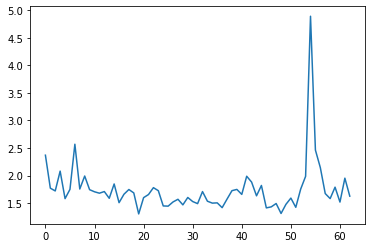

Epoch 1/100
11/11 - 2s - loss: 1.8082 - accuracy: 0.2857 - auc_34: 0.5162 - precision_34: 0.4091 - recall_34: 0.0274 - f1_score: 0.2027 - val_loss: 1.7239 - val_accuracy: 0.6486 - val_auc_34: 0.8017 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.1967 - 2s/epoch - 223ms/step
Epoch 2/100
11/11 - 0s - loss: 2.2447 - accuracy: 0.3252 - auc_34: 0.6057 - precision_34: 0.2340 - recall_34: 0.0334 - f1_score: 0.1801 - val_loss: 2.9931 - val_accuracy: 0.0270 - val_auc_34: 0.4081 - val_precision_34: 0.5000 - val_recall_34: 0.0270 - val_f1_score: 0.0500 - 277ms/epoch - 25ms/step
Epoch 3/100
11/11 - 0s - loss: 2.1395 - accuracy: 0.1185 - auc_34: 0.4028 - precision_34: 0.1818 - recall_34: 0.0973 - f1_score: 0.1346 - val_loss: 3.0786 - val_accuracy: 0.0000e+00 - val_auc_34: 0.1577 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.0000e+00 - 273ms/epoch - 25ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6958 - accuracy: 0.1033 - auc_34: 0.3784 - preci

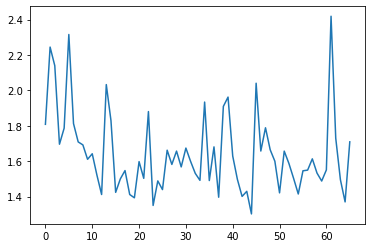

Epoch 1/100
11/11 - 3s - loss: 2.2448 - accuracy: 0.1429 - auc_35: 0.4933 - precision_35: 0.1909 - recall_35: 0.0638 - f1_score: 0.1236 - val_loss: 1.5547 - val_accuracy: 0.7297 - val_auc_35: 0.7604 - val_precision_35: 0.5000 - val_recall_35: 0.0270 - val_f1_score: 0.3347 - 3s/epoch - 249ms/step
Epoch 2/100
11/11 - 0s - loss: 1.9957 - accuracy: 0.3374 - auc_35: 0.5827 - precision_35: 0.2857 - recall_35: 0.0365 - f1_score: 0.2173 - val_loss: 1.5841 - val_accuracy: 0.0270 - val_auc_35: 0.4195 - val_precision_35: 0.5000 - val_recall_35: 0.0270 - val_f1_score: 0.1667 - 283ms/epoch - 26ms/step
Epoch 3/100
11/11 - 0s - loss: 1.6733 - accuracy: 0.0699 - auc_35: 0.3501 - precision_35: 0.3077 - recall_35: 0.0365 - f1_score: 0.1125 - val_loss: 1.7331 - val_accuracy: 0.7297 - val_auc_35: 0.6999 - val_precision_35: 0.5000 - val_recall_35: 0.0270 - val_f1_score: 0.3347 - 272ms/epoch - 25ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6565 - accuracy: 0.1733 - auc_35: 0.5137 - precision_35: 0.4000 - recall

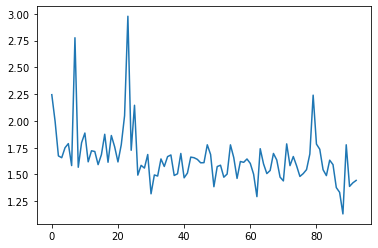

Epoch 1/100
11/11 - 3s - loss: 2.0269 - accuracy: 0.2818 - auc_36: 0.5700 - precision_36: 0.2609 - recall_36: 0.0545 - f1_score: 0.1952 - val_loss: 3.4347 - val_accuracy: 0.7222 - val_auc_36: 0.8449 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.2097 - 3s/epoch - 231ms/step
Epoch 2/100
11/11 - 0s - loss: 1.9064 - accuracy: 0.2303 - auc_36: 0.5590 - precision_36: 0.2935 - recall_36: 0.0818 - f1_score: 0.1589 - val_loss: 2.2944 - val_accuracy: 0.7222 - val_auc_36: 0.8227 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.2131 - 291ms/epoch - 26ms/step
Epoch 3/100
11/11 - 0s - loss: 1.9460 - accuracy: 0.5242 - auc_36: 0.6501 - precision_36: 0.4800 - recall_36: 0.0364 - f1_score: 0.2597 - val_loss: 2.2035 - val_accuracy: 0.0000e+00 - val_auc_36: 0.1469 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.0000e+00 - 291ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 2.2038 - accuracy: 0.0848 - auc_36: 0.3669

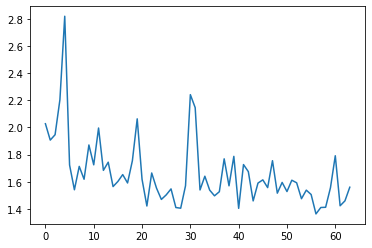

Epoch 1/100
11/11 - 2s - loss: 3.0168 - accuracy: 0.3273 - auc_37: 0.6371 - precision_37: 0.2288 - recall_37: 0.0818 - f1_score: 0.2255 - val_loss: 5.1510 - val_accuracy: 0.5833 - val_auc_37: 0.7500 - val_precision_37: 0.0000e+00 - val_recall_37: 0.0000e+00 - val_f1_score: 0.1842 - 2s/epoch - 225ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5829 - accuracy: 0.2727 - auc_37: 0.5993 - precision_37: 0.2619 - recall_37: 0.0333 - f1_score: 0.2161 - val_loss: 1.5860 - val_accuracy: 0.0833 - val_auc_37: 0.4299 - val_precision_37: 0.6667 - val_recall_37: 0.0556 - val_f1_score: 0.1147 - 296ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.4848 - accuracy: 0.2152 - auc_37: 0.5375 - precision_37: 0.2524 - recall_37: 0.0788 - f1_score: 0.1869 - val_loss: 1.4890 - val_accuracy: 0.6389 - val_auc_37: 0.7885 - val_precision_37: 0.6667 - val_recall_37: 0.0556 - val_f1_score: 0.2818 - 285ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 1.5635 - accuracy: 0.3242 - auc_37: 0.5538 - precision_37: 0.3425 

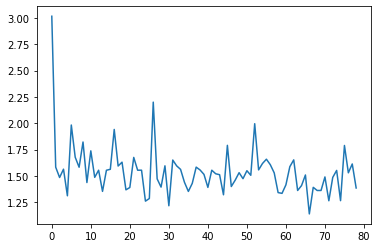

Epoch 1/100
11/11 - 2s - loss: 2.1209 - accuracy: 0.3879 - auc_38: 0.6761 - precision_38: 0.4519 - recall_38: 0.1424 - f1_score: 0.2536 - val_loss: 2.9305 - val_accuracy: 0.5556 - val_auc_38: 0.7442 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_f1_score: 0.1786 - 2s/epoch - 222ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5775 - accuracy: 0.3697 - auc_38: 0.6820 - precision_38: 0.3333 - recall_38: 0.0424 - f1_score: 0.2373 - val_loss: 2.0755 - val_accuracy: 0.2222 - val_auc_38: 0.6523 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_f1_score: 0.0909 - 296ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.6262 - accuracy: 0.3909 - auc_38: 0.6809 - precision_38: 0.4557 - recall_38: 0.1091 - f1_score: 0.2466 - val_loss: 1.2556 - val_accuracy: 0.2500 - val_auc_38: 0.6854 - val_precision_38: 1.0000 - val_recall_38: 0.0278 - val_f1_score: 0.1555 - 290ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 1.9130 - accuracy: 0.2909 - auc_38: 0.5618 - precision_38:

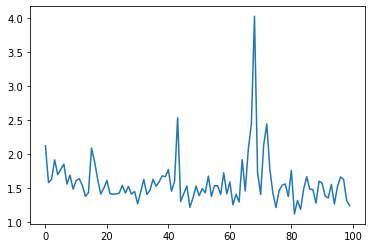

Epoch 1/100
11/11 - 3s - loss: 1.7160 - accuracy: 0.2515 - auc_39: 0.5648 - precision_39: 0.5051 - recall_39: 0.1515 - f1_score: 0.1907 - val_loss: 2.8297 - val_accuracy: 0.1389 - val_auc_39: 0.2478 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.0625 - 3s/epoch - 261ms/step
Epoch 2/100
11/11 - 0s - loss: 1.8831 - accuracy: 0.2030 - auc_39: 0.5244 - precision_39: 0.2000 - recall_39: 0.0545 - f1_score: 0.1763 - val_loss: 1.8625 - val_accuracy: 0.1389 - val_auc_39: 0.5756 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.0610 - 294ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.7383 - accuracy: 0.2788 - auc_39: 0.5931 - precision_39: 0.3293 - recall_39: 0.0818 - f1_score: 0.2337 - val_loss: 2.7061 - val_accuracy: 0.1667 - val_auc_39: 0.2384 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.0714 - 281ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6921 - accuracy: 0.0576 - auc_39: 0.2857 - preci

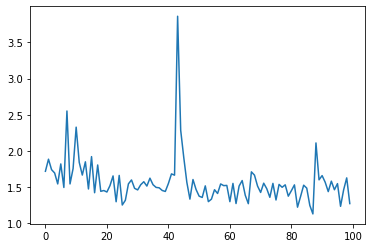

In [38]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_area_face_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_area_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_face_model.save(model_path / 'face_area_rcnn.h5')

#### Training performance and variance

In [39]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.36416965797543527,
 'ROC/AUC': 0.6414776533842087,
 'Precision': 0.48460362255573275,
 'Recall': 0.12474624961614608,
 'F1-score': 0.29948910027742387}

In [40]:
face_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_rcnn_train_var

{'Accuracy': 0.02167722095975249,
 'ROC/AUC': 0.018402782460350417,
 'Precision': 0.01778886945000143,
 'Recall': 0.002302392610232105,
 'F1-score': 0.01167500158776074}

#### Validation performance and variance

In [41]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.29744744915515187,
 'ROC/AUC': 0.6078677594661712,
 'Precision': 0.41666666865348817,
 'Recall': 0.019144144468009473,
 'F1-score': 0.12522494252771138}

In [42]:
face_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_rcnn_val_var

{'Accuracy': 0.04504964193099849,
 'ROC/AUC': 0.01306024773052549,
 'Precision': 0.1458333343267441,
 'Recall': 0.00031148829759066604,
 'F1-score': 0.005605720450276918}

#### Predictions and performance on test set

In [43]:
rcnn_area_face_model = load_model(model_path / 'face_area_rcnn.h5')
y_pred = rcnn_area_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_face_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 10ms/step - loss: 1.3510 - accuracy: 0.5368 - auc_38: 0.7370 - precision_38: 0.3333 - recall_38: 0.0087 - f1_score: 0.1970
Accuracy: 53.68% 
ROC/AUC: 0.74 
Precision: 0.33 
Recall: 0.01 
F1 score: 0.20


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

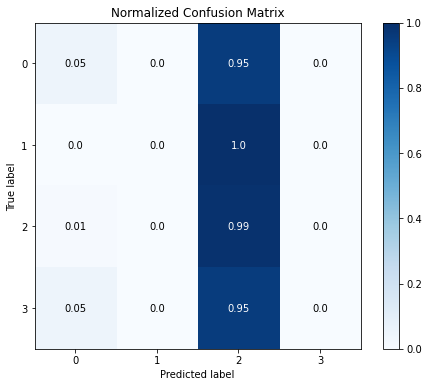

In [44]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

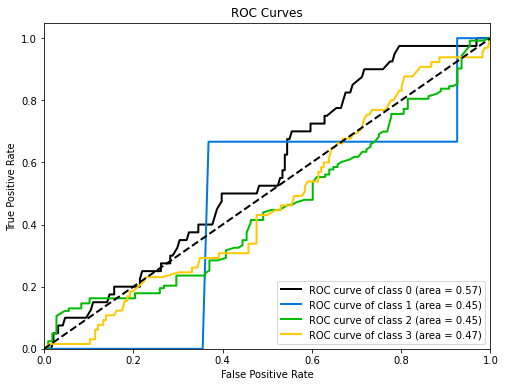

In [45]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

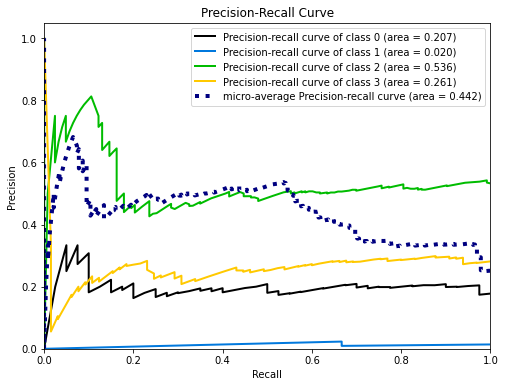

In [46]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

## 3. Multimodal Early Fusion

In [47]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 60) (366, 4)
(231, 1, 350, 60) (231, 4)


### 3.1 CNN + BiLSTM

Epoch 1/100
11/11 - 8s - loss: 1.4264 - accuracy: 0.2188 - auc_40: 0.5267 - precision_40: 0.0000e+00 - recall_40: 0.0000e+00 - f1_score: 0.1634 - val_loss: 1.3411 - val_accuracy: 0.1892 - val_auc_40: 0.6749 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_f1_score: 0.0795 - 8s/epoch - 731ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3853 - accuracy: 0.3891 - auc_40: 0.6497 - precision_40: 1.0000 - recall_40: 0.0091 - f1_score: 0.2466 - val_loss: 1.3431 - val_accuracy: 0.1892 - val_auc_40: 0.6736 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_f1_score: 0.0795 - 1s/epoch - 108ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3146 - accuracy: 0.4802 - auc_40: 0.7293 - precision_40: 0.7500 - recall_40: 0.0182 - f1_score: 0.3162 - val_loss: 1.3320 - val_accuracy: 0.2703 - val_auc_40: 0.6871 - val_precision_40: 1.0000 - val_recall_40: 0.0270 - val_f1_score: 0.1454 - 1s/epoch - 110ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2708 - accuracy: 0.5319 - auc_40: 0.7684 - precision

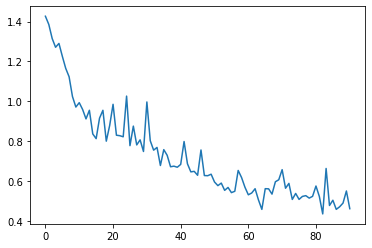

Epoch 1/100
11/11 - 8s - loss: 1.4681 - accuracy: 0.3343 - auc_41: 0.6616 - precision_41: 0.0000e+00 - recall_41: 0.0000e+00 - f1_score: 0.2229 - val_loss: 1.3724 - val_accuracy: 0.2162 - val_auc_41: 0.6168 - val_precision_41: 0.0000e+00 - val_recall_41: 0.0000e+00 - val_f1_score: 0.1132 - 8s/epoch - 696ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3931 - accuracy: 0.3495 - auc_41: 0.6924 - precision_41: 1.0000 - recall_41: 0.0030 - f1_score: 0.2523 - val_loss: 1.3846 - val_accuracy: 0.1892 - val_auc_41: 0.4817 - val_precision_41: 0.0000e+00 - val_recall_41: 0.0000e+00 - val_f1_score: 0.0998 - 1s/epoch - 108ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3777 - accuracy: 0.4073 - auc_41: 0.6713 - precision_41: 1.0000 - recall_41: 0.0182 - f1_score: 0.2924 - val_loss: 1.3914 - val_accuracy: 0.0270 - val_auc_41: 0.3494 - val_precision_41: 0.0000e+00 - val_recall_41: 0.0000e+00 - val_f1_score: 0.0312 - 1s/epoch - 109ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3409 - accuracy: 0.1216 - auc_41: 0.4098 - p

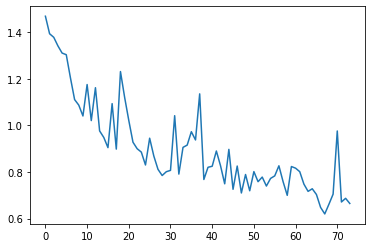

Epoch 1/100
11/11 - 8s - loss: 1.3363 - accuracy: 0.2857 - auc_42: 0.5976 - precision_42: 0.0000e+00 - recall_42: 0.0000e+00 - f1_score: 0.2096 - val_loss: 1.3833 - val_accuracy: 0.2162 - val_auc_42: 0.4753 - val_precision_42: 0.0000e+00 - val_recall_42: 0.0000e+00 - val_f1_score: 0.1605 - 8s/epoch - 690ms/step
Epoch 2/100
11/11 - 1s - loss: 1.2943 - accuracy: 0.4164 - auc_42: 0.7218 - precision_42: 1.0000 - recall_42: 0.0122 - f1_score: 0.2730 - val_loss: 1.3676 - val_accuracy: 0.2973 - val_auc_42: 0.6664 - val_precision_42: 0.0000e+00 - val_recall_42: 0.0000e+00 - val_f1_score: 0.1636 - 1s/epoch - 111ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2871 - accuracy: 0.4681 - auc_42: 0.7361 - precision_42: 0.6364 - recall_42: 0.0213 - f1_score: 0.2796 - val_loss: 1.3671 - val_accuracy: 0.3243 - val_auc_42: 0.6032 - val_precision_42: 0.0000e+00 - val_recall_42: 0.0000e+00 - val_f1_score: 0.1822 - 1s/epoch - 110ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2695 - accuracy: 0.4134 - auc_42: 0.7200 - p

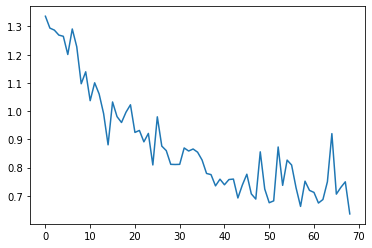

Epoch 1/100
11/11 - 9s - loss: 1.4269 - accuracy: 0.3222 - auc_43: 0.6380 - precision_43: 0.0000e+00 - recall_43: 0.0000e+00 - f1_score: 0.1806 - val_loss: 1.3543 - val_accuracy: 0.1892 - val_auc_43: 0.6502 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00 - val_f1_score: 0.0795 - 9s/epoch - 789ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3795 - accuracy: 0.2462 - auc_43: 0.5868 - precision_43: 0.6000 - recall_43: 0.0091 - f1_score: 0.1935 - val_loss: 1.3721 - val_accuracy: 0.1892 - val_auc_43: 0.6581 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00 - val_f1_score: 0.0795 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3240 - accuracy: 0.2979 - auc_43: 0.6119 - precision_43: 0.7778 - recall_43: 0.0213 - f1_score: 0.2418 - val_loss: 1.3671 - val_accuracy: 0.2432 - val_auc_43: 0.6949 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00 - val_f1_score: 0.1341 - 1s/epoch - 120ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3776 - accuracy: 0.4134 - auc_43: 0.6997 - p

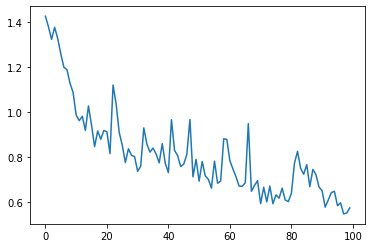

Epoch 1/100
11/11 - 8s - loss: 1.4638 - accuracy: 0.3252 - auc_44: 0.6260 - precision_44: 0.0000e+00 - recall_44: 0.0000e+00 - f1_score: 0.2268 - val_loss: 1.3838 - val_accuracy: 0.0811 - val_auc_44: 0.5860 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.0375 - 8s/epoch - 768ms/step
Epoch 2/100
11/11 - 1s - loss: 1.4298 - accuracy: 0.3343 - auc_44: 0.6688 - precision_44: 0.8333 - recall_44: 0.0152 - f1_score: 0.2533 - val_loss: 1.3975 - val_accuracy: 0.1081 - val_auc_44: 0.5248 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.0584 - 1s/epoch - 120ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3861 - accuracy: 0.3191 - auc_44: 0.6043 - precision_44: 0.8571 - recall_44: 0.0182 - f1_score: 0.2655 - val_loss: 1.3998 - val_accuracy: 0.3514 - val_auc_44: 0.6389 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.1775 - 1s/epoch - 120ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3508 - accuracy: 0.5046 - auc_44: 0.7761 - p

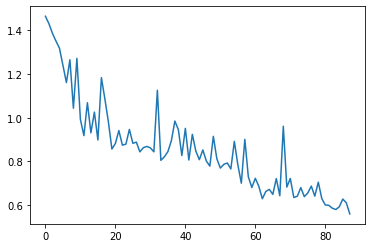

Epoch 1/100
11/11 - 9s - loss: 1.4487 - accuracy: 0.2675 - auc_45: 0.6211 - precision_45: 0.0000e+00 - recall_45: 0.0000e+00 - f1_score: 0.1512 - val_loss: 1.4120 - val_accuracy: 0.0541 - val_auc_45: 0.4557 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.0256 - 9s/epoch - 776ms/step
Epoch 2/100
11/11 - 1s - loss: 1.4140 - accuracy: 0.3343 - auc_45: 0.6788 - precision_45: 1.0000 - recall_45: 0.0061 - f1_score: 0.2172 - val_loss: 1.3998 - val_accuracy: 0.0541 - val_auc_45: 0.4396 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.0256 - 1s/epoch - 122ms/step
Epoch 3/100
11/11 - 1s - loss: 1.4562 - accuracy: 0.4134 - auc_45: 0.6989 - precision_45: 0.7143 - recall_45: 0.0152 - f1_score: 0.2872 - val_loss: 1.3933 - val_accuracy: 0.0541 - val_auc_45: 0.4310 - val_precision_45: 1.0000 - val_recall_45: 0.0270 - val_f1_score: 0.0278 - 1s/epoch - 121ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3836 - accuracy: 0.3982 - auc_45: 0.6598 - precision

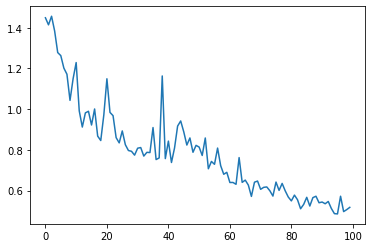

Epoch 1/100
11/11 - 9s - loss: 1.4666 - accuracy: 0.2394 - auc_46: 0.5680 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - f1_score: 0.1752 - val_loss: 1.3748 - val_accuracy: 0.1667 - val_auc_46: 0.5806 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.1458 - 9s/epoch - 774ms/step
Epoch 2/100
11/11 - 1s - loss: 1.4306 - accuracy: 0.3758 - auc_46: 0.6955 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - f1_score: 0.2333 - val_loss: 1.3659 - val_accuracy: 0.1944 - val_auc_46: 0.7049 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.1719 - 1s/epoch - 122ms/step
Epoch 3/100
11/11 - 1s - loss: 1.3807 - accuracy: 0.4273 - auc_46: 0.7227 - precision_46: 0.7500 - recall_46: 0.0091 - f1_score: 0.2924 - val_loss: 1.3748 - val_accuracy: 0.2778 - val_auc_46: 0.5842 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.1987 - 1s/epoch - 119ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3380 - accuracy: 0.3515 - auc_46: 0.

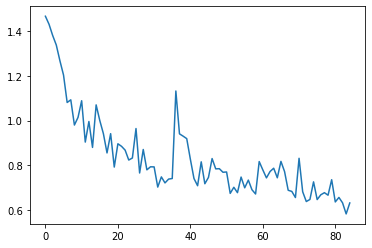

Epoch 1/100
11/11 - 9s - loss: 1.3217 - accuracy: 0.4606 - auc_47: 0.7210 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - f1_score: 0.2156 - val_loss: 1.3062 - val_accuracy: 0.2222 - val_auc_47: 0.6984 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.0909 - 9s/epoch - 782ms/step
Epoch 2/100
11/11 - 1s - loss: 1.2864 - accuracy: 0.4818 - auc_47: 0.7508 - precision_47: 0.7500 - recall_47: 0.0091 - f1_score: 0.2513 - val_loss: 1.3087 - val_accuracy: 0.2222 - val_auc_47: 0.5554 - val_precision_47: 1.0000 - val_recall_47: 0.0556 - val_f1_score: 0.0909 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2683 - accuracy: 0.5000 - auc_47: 0.7681 - precision_47: 0.7143 - recall_47: 0.0152 - f1_score: 0.4217 - val_loss: 1.3023 - val_accuracy: 0.2222 - val_auc_47: 0.6064 - val_precision_47: 1.0000 - val_recall_47: 0.0556 - val_f1_score: 0.0909 - 1s/epoch - 122ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3493 - accuracy: 0.3182 - auc_47: 0.6732 - precision_47: 0.5

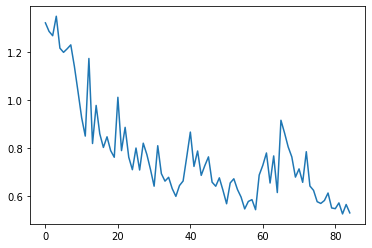

Epoch 1/100
11/11 - 8s - loss: 1.3016 - accuracy: 0.5606 - auc_48: 0.7762 - precision_48: 0.0000e+00 - recall_48: 0.0000e+00 - f1_score: 0.2382 - val_loss: 1.3364 - val_accuracy: 0.1944 - val_auc_48: 0.6408 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_f1_score: 0.0814 - 8s/epoch - 733ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3099 - accuracy: 0.5455 - auc_48: 0.7722 - precision_48: 0.7500 - recall_48: 0.0182 - f1_score: 0.2743 - val_loss: 1.3444 - val_accuracy: 0.2778 - val_auc_48: 0.6613 - val_precision_48: 1.0000 - val_recall_48: 0.0278 - val_f1_score: 0.1607 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2756 - accuracy: 0.6030 - auc_48: 0.8209 - precision_48: 0.7500 - recall_48: 0.0182 - f1_score: 0.3007 - val_loss: 1.3517 - val_accuracy: 0.3333 - val_auc_48: 0.6533 - val_precision_48: 1.0000 - val_recall_48: 0.0278 - val_f1_score: 0.2208 - 1s/epoch - 120ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1589 - accuracy: 0.5152 - auc_48: 0.8047 - precision_48: 0.7

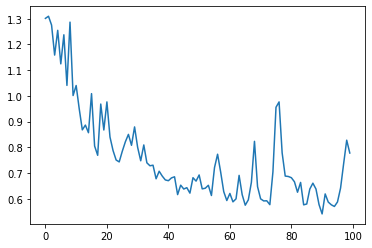

Epoch 1/100
11/11 - 9s - loss: 1.3501 - accuracy: 0.1697 - auc_49: 0.3478 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.1490 - val_loss: 1.3617 - val_accuracy: 0.1667 - val_auc_49: 0.6690 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.0714 - 9s/epoch - 794ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3045 - accuracy: 0.4242 - auc_49: 0.7187 - precision_49: 0.6667 - recall_49: 0.0061 - f1_score: 0.2856 - val_loss: 1.3430 - val_accuracy: 0.5000 - val_auc_49: 0.7774 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.2258 - 1s/epoch - 121ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2654 - accuracy: 0.4909 - auc_49: 0.7716 - precision_49: 0.7500 - recall_49: 0.0182 - f1_score: 0.3039 - val_loss: 1.3465 - val_accuracy: 0.5278 - val_auc_49: 0.7882 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.2533 - 1s/epoch - 120ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2115 - accuracy: 0.5091 - auc_49: 0.7872 - p

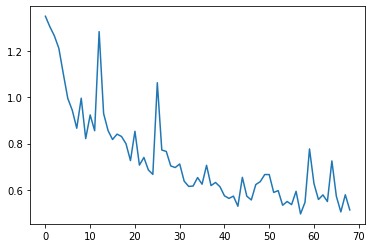

In [48]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_area_earlyfusion_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_earlyfusion_model.save(model_path / 'early_area_cnnlstm.h5')

#### Training performance and variance

In [49]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.6448328375816346,
 'ROC/AUC': 0.882666927576065,
 'Precision': 0.6871861815452576,
 'Recall': 0.5583135277032852,
 'F1-score': 0.5748930096626281}

In [50]:
early_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_cnnlstm_train_var

{'Accuracy': 0.0022861505609638754,
 'ROC/AUC': 0.0007485387581390413,
 'Precision': 0.001872010596089524,
 'Recall': 0.00556524388574645,
 'F1-score': 0.0033299007903478646}

#### Validation performance and variance

In [51]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.4477477490901947,
 'ROC/AUC': 0.7381472587585449,
 'Precision': 0.4385528687387705,
 'Recall': 0.3578828813508153,
 'F1-score': 0.27929127067327497}

In [52]:
early_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_cnnlstm_val_var

{'Accuracy': 0.020928836345311584,
 'ROC/AUC': 0.006047048921377751,
 'Precision': 0.03764735807049001,
 'Recall': 0.03117092905700814,
 'F1-score': 0.008700631386552015}

#### Predictions and performance on test set

In [53]:
cnnlstm_area_earlyfusion_model = load_model(model_path / 'early_area_cnnlstm.h5')
y_pred = cnnlstm_area_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_area_earlyfusion_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 36ms/step - loss: 1.7000 - accuracy: 0.3896 - auc_45: 0.6775 - precision_45: 0.3920 - recall_45: 0.3377 - f1_score: 0.2380
Accuracy: 38.96% 
ROC/AUC: 0.68 
Precision: 0.39 
Recall: 0.34 
F1 score: 0.24


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

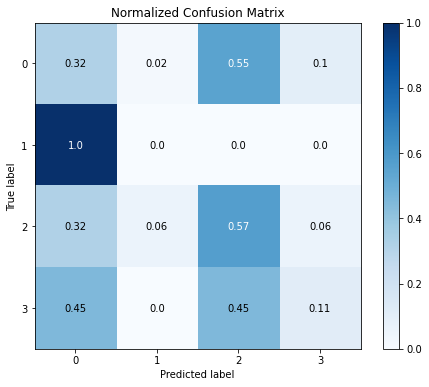

In [54]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

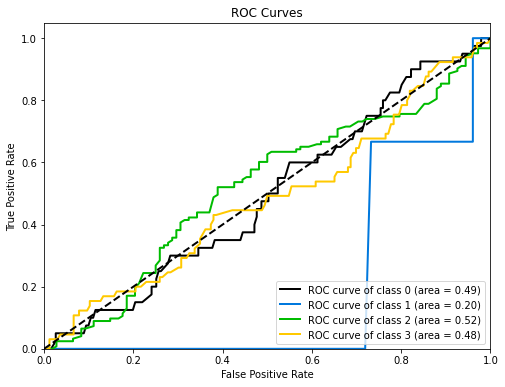

In [55]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

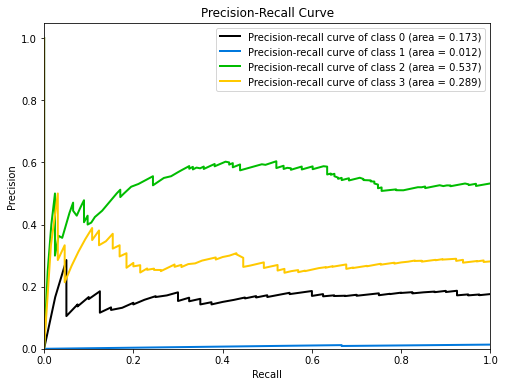

In [57]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 3.2 RCNN

Epoch 1/100
11/11 - 3s - loss: 1.9474 - accuracy: 0.2401 - auc_50: 0.5972 - precision_50: 0.2857 - recall_50: 0.0486 - f1_score: 0.1877 - val_loss: 1.2752 - val_accuracy: 0.6216 - val_auc_50: 0.8232 - val_precision_50: 1.0000 - val_recall_50: 0.0270 - val_f1_score: 0.2522 - 3s/epoch - 248ms/step
Epoch 2/100
11/11 - 0s - loss: 1.6902 - accuracy: 0.3799 - auc_50: 0.6918 - precision_50: 0.4545 - recall_50: 0.0304 - f1_score: 0.2253 - val_loss: 1.3718 - val_accuracy: 0.2432 - val_auc_50: 0.3803 - val_precision_50: 1.0000 - val_recall_50: 0.0270 - val_f1_score: 0.1534 - 321ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.7597 - accuracy: 0.3921 - auc_50: 0.5863 - precision_50: 0.3279 - recall_50: 0.0608 - f1_score: 0.2514 - val_loss: 1.5562 - val_accuracy: 0.0270 - val_auc_50: 0.2462 - val_precision_50: 1.0000 - val_recall_50: 0.0270 - val_f1_score: 0.0625 - 312ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.8468 - accuracy: 0.0669 - auc_50: 0.4283 - precision_50: 0.0949 - recall

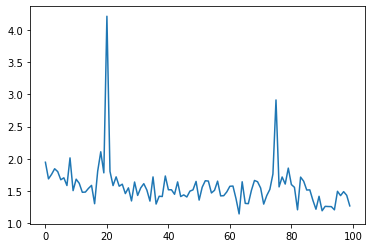

Epoch 1/100
11/11 - 3s - loss: 2.2500 - accuracy: 0.4316 - auc_51: 0.6705 - precision_51: 0.3333 - recall_51: 0.0729 - f1_score: 0.2641 - val_loss: 4.1242 - val_accuracy: 0.0270 - val_auc_51: 0.3720 - val_precision_51: 0.5000 - val_recall_51: 0.0270 - val_f1_score: 0.0500 - 3s/epoch - 239ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5010 - accuracy: 0.1429 - auc_51: 0.4415 - precision_51: 0.2679 - recall_51: 0.0456 - f1_score: 0.1409 - val_loss: 4.1378 - val_accuracy: 0.0270 - val_auc_51: 0.3522 - val_precision_51: 0.5000 - val_recall_51: 0.0270 - val_f1_score: 0.0625 - 322ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.5142 - accuracy: 0.0334 - auc_51: 0.3677 - precision_51: 0.1084 - recall_51: 0.0274 - f1_score: 0.0601 - val_loss: 2.8020 - val_accuracy: 0.0270 - val_auc_51: 0.3466 - val_precision_51: 0.5000 - val_recall_51: 0.0270 - val_f1_score: 0.0625 - 317ms/epoch - 29ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6310 - accuracy: 0.2097 - auc_51: 0.5216 - precision_51: 0.2698 - recall

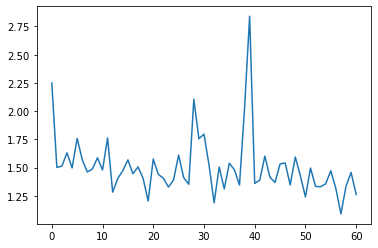

Epoch 1/100
11/11 - 3s - loss: 2.3591 - accuracy: 0.2462 - auc_52: 0.5928 - precision_52: 0.2946 - recall_52: 0.1155 - f1_score: 0.2646 - val_loss: 2.0359 - val_accuracy: 0.0270 - val_auc_52: 0.3562 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.0132 - 3s/epoch - 240ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5670 - accuracy: 0.3343 - auc_52: 0.6022 - precision_52: 0.2639 - recall_52: 0.0578 - f1_score: 0.2428 - val_loss: 1.5687 - val_accuracy: 0.6486 - val_auc_52: 0.7700 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.2000 - 322ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.5463 - accuracy: 0.3070 - auc_52: 0.6507 - precision_52: 0.4194 - recall_52: 0.0790 - f1_score: 0.2279 - val_loss: 1.8572 - val_accuracy: 0.1622 - val_auc_52: 0.6045 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.0698 - 301ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 1.5366 - accuracy: 0.2340 - auc_52: 0.5712 - preci

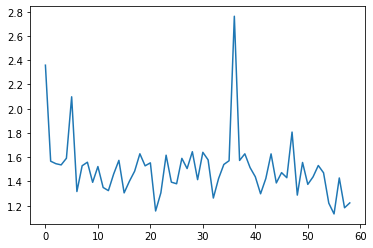

Epoch 1/100
11/11 - 3s - loss: 1.7218 - accuracy: 0.2705 - auc_53: 0.4960 - precision_53: 0.2778 - recall_53: 0.0760 - f1_score: 0.1915 - val_loss: 1.4535 - val_accuracy: 0.1622 - val_auc_53: 0.5756 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00 - val_f1_score: 0.0714 - 3s/epoch - 270ms/step
Epoch 2/100
11/11 - 0s - loss: 1.4896 - accuracy: 0.2492 - auc_53: 0.6179 - precision_53: 0.3333 - recall_53: 0.1003 - f1_score: 0.1929 - val_loss: 1.2875 - val_accuracy: 0.2162 - val_auc_53: 0.6758 - val_precision_53: 1.0000 - val_recall_53: 0.0541 - val_f1_score: 0.1031 - 318ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 2.2382 - accuracy: 0.2219 - auc_53: 0.5071 - precision_53: 0.2734 - recall_53: 0.1064 - f1_score: 0.1792 - val_loss: 1.8186 - val_accuracy: 0.5946 - val_auc_53: 0.6558 - val_precision_53: 0.5000 - val_recall_53: 0.0270 - val_f1_score: 0.1864 - 319ms/epoch - 29ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6674 - accuracy: 0.3526 - auc_53: 0.6441 - precision_53: 0.3529 

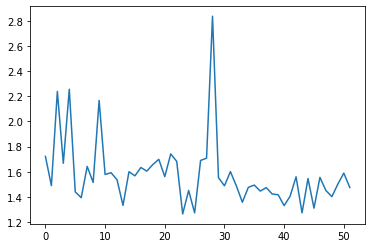

Epoch 1/100
11/11 - 3s - loss: 2.1758 - accuracy: 0.1884 - auc_54: 0.4710 - precision_54: 0.1466 - recall_54: 0.0517 - f1_score: 0.1753 - val_loss: 1.6976 - val_accuracy: 0.2162 - val_auc_54: 0.4446 - val_precision_54: 0.0000e+00 - val_recall_54: 0.0000e+00 - val_f1_score: 0.0909 - 3s/epoch - 240ms/step
Epoch 2/100
11/11 - 0s - loss: 1.6347 - accuracy: 0.1641 - auc_54: 0.4781 - precision_54: 0.3293 - recall_54: 0.0821 - f1_score: 0.1522 - val_loss: 1.3224 - val_accuracy: 0.6757 - val_auc_54: 0.8179 - val_precision_54: 0.5000 - val_recall_54: 0.0270 - val_f1_score: 0.2016 - 324ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.5889 - accuracy: 0.3860 - auc_54: 0.6283 - precision_54: 0.3710 - recall_54: 0.1398 - f1_score: 0.2582 - val_loss: 1.8440 - val_accuracy: 0.6486 - val_auc_54: 0.6875 - val_precision_54: 0.0000e+00 - val_recall_54: 0.0000e+00 - val_f1_score: 0.1967 - 308ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6627 - accuracy: 0.1702 - auc_54: 0.4710 - precision_54:

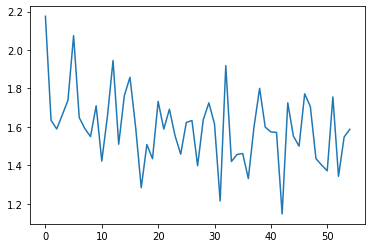

Epoch 1/100
11/11 - 3s - loss: 2.1948 - accuracy: 0.1733 - auc_55: 0.4915 - precision_55: 0.2222 - recall_55: 0.0426 - f1_score: 0.1502 - val_loss: 2.1247 - val_accuracy: 0.7297 - val_auc_55: 0.8041 - val_precision_55: 0.5000 - val_recall_55: 0.0270 - val_f1_score: 0.2109 - 3s/epoch - 240ms/step
Epoch 2/100
11/11 - 0s - loss: 2.0855 - accuracy: 0.1915 - auc_55: 0.5385 - precision_55: 0.3053 - recall_55: 0.1216 - f1_score: 0.1541 - val_loss: 1.4687 - val_accuracy: 0.0270 - val_auc_55: 0.1857 - val_precision_55: 0.5000 - val_recall_55: 0.0270 - val_f1_score: 0.1667 - 319ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.6003 - accuracy: 0.2310 - auc_55: 0.5402 - precision_55: 0.3918 - recall_55: 0.1155 - f1_score: 0.2004 - val_loss: 1.4272 - val_accuracy: 0.0000e+00 - val_auc_55: 0.5430 - val_precision_55: 0.0000e+00 - val_recall_55: 0.0000e+00 - val_f1_score: 0.0000e+00 - 316ms/epoch - 29ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6307 - accuracy: 0.1429 - auc_55: 0.3258 - precision_55:

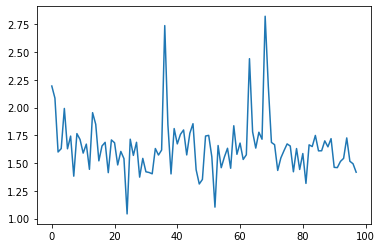

Epoch 1/100
11/11 - 3s - loss: 1.9305 - accuracy: 0.2818 - auc_56: 0.5381 - precision_56: 0.3158 - recall_56: 0.0545 - f1_score: 0.2065 - val_loss: 1.3254 - val_accuracy: 0.1944 - val_auc_56: 0.6454 - val_precision_56: 1.0000 - val_recall_56: 0.0278 - val_f1_score: 0.1041 - 3s/epoch - 241ms/step
Epoch 2/100
11/11 - 0s - loss: 2.2654 - accuracy: 0.1939 - auc_56: 0.5302 - precision_56: 0.1651 - recall_56: 0.0545 - f1_score: 0.1488 - val_loss: 1.3728 - val_accuracy: 0.0278 - val_auc_56: 0.5633 - val_precision_56: 1.0000 - val_recall_56: 0.0278 - val_f1_score: 0.0833 - 312ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.6443 - accuracy: 0.1455 - auc_56: 0.4189 - precision_56: 0.3714 - recall_56: 0.0788 - f1_score: 0.1629 - val_loss: 1.8133 - val_accuracy: 0.7222 - val_auc_56: 0.8116 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00 - val_f1_score: 0.2097 - 307ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 2.1107 - accuracy: 0.3606 - auc_56: 0.6300 - precision_56: 0.4182 

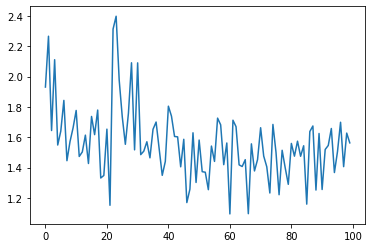

Epoch 1/100
11/11 - 3s - loss: 2.5219 - accuracy: 0.3636 - auc_57: 0.6134 - precision_57: 0.1827 - recall_57: 0.0576 - f1_score: 0.2407 - val_loss: 1.4698 - val_accuracy: 0.2222 - val_auc_57: 0.4101 - val_precision_57: 0.6667 - val_recall_57: 0.0556 - val_f1_score: 0.0909 - 3s/epoch - 277ms/step
Epoch 2/100
11/11 - 0s - loss: 1.4718 - accuracy: 0.2303 - auc_57: 0.5393 - precision_57: 0.2952 - recall_57: 0.0939 - f1_score: 0.1963 - val_loss: 2.3286 - val_accuracy: 0.0278 - val_auc_57: 0.2142 - val_precision_57: 0.0000e+00 - val_recall_57: 0.0000e+00 - val_f1_score: 0.0147 - 320ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.7677 - accuracy: 0.1030 - auc_57: 0.3733 - precision_57: 0.1105 - recall_57: 0.0576 - f1_score: 0.1277 - val_loss: 1.3086 - val_accuracy: 0.4167 - val_auc_57: 0.6692 - val_precision_57: 0.3333 - val_recall_57: 0.0278 - val_f1_score: 0.1964 - 320ms/epoch - 29ms/step
Epoch 4/100
11/11 - 0s - loss: 1.5224 - accuracy: 0.4515 - auc_57: 0.6530 - precision_57: 0.4742 

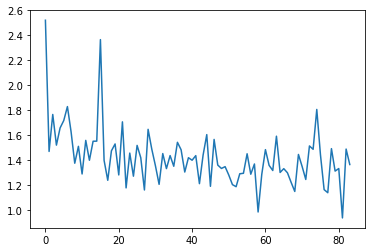

Epoch 1/100
11/11 - 3s - loss: 1.7492 - accuracy: 0.2515 - auc_58: 0.5235 - precision_58: 0.3125 - recall_58: 0.0606 - f1_score: 0.1921 - val_loss: 1.2631 - val_accuracy: 0.5833 - val_auc_58: 0.7836 - val_precision_58: 1.0000 - val_recall_58: 0.0278 - val_f1_score: 0.2443 - 3s/epoch - 242ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5424 - accuracy: 0.5121 - auc_58: 0.6796 - precision_58: 0.4623 - recall_58: 0.1485 - f1_score: 0.3126 - val_loss: 1.4363 - val_accuracy: 0.2500 - val_auc_58: 0.3915 - val_precision_58: 1.0000 - val_recall_58: 0.0278 - val_f1_score: 0.1555 - 310ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.5733 - accuracy: 0.1515 - auc_58: 0.3639 - precision_58: 0.3929 - recall_58: 0.0667 - f1_score: 0.1581 - val_loss: 1.3394 - val_accuracy: 0.0556 - val_auc_58: 0.5156 - val_precision_58: 1.0000 - val_recall_58: 0.0278 - val_f1_score: 0.0768 - 312ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6501 - accuracy: 0.2970 - auc_58: 0.5999 - precision_58: 0.3241 - recall

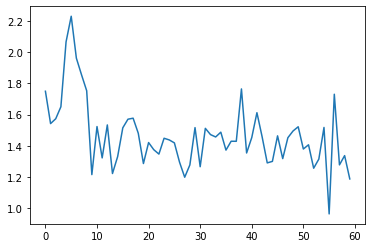

Epoch 1/100
11/11 - 3s - loss: 2.3426 - accuracy: 0.2121 - auc_59: 0.5613 - precision_59: 0.2327 - recall_59: 0.1121 - f1_score: 0.1557 - val_loss: 1.8948 - val_accuracy: 0.1667 - val_auc_59: 0.6001 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.0714 - 3s/epoch - 242ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5983 - accuracy: 0.2545 - auc_59: 0.4994 - precision_59: 0.2647 - recall_59: 0.0545 - f1_score: 0.2149 - val_loss: 1.4331 - val_accuracy: 0.6389 - val_auc_59: 0.7616 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.1949 - 334ms/epoch - 30ms/step
Epoch 3/100
11/11 - 0s - loss: 1.5707 - accuracy: 0.3061 - auc_59: 0.6109 - precision_59: 0.3875 - recall_59: 0.0939 - f1_score: 0.2270 - val_loss: 1.2405 - val_accuracy: 0.6389 - val_auc_59: 0.7778 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.1949 - 319ms/epoch - 29ms/step
Epoch 4/100
11/11 - 0s - loss: 1.4718 - accuracy: 0.4455 - auc_59: 0.6576 - preci

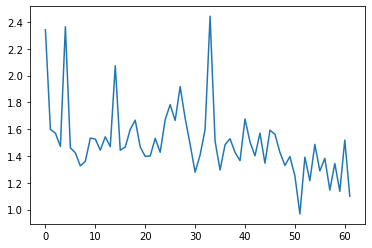

In [58]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_area_earlyfusion_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_area_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_earlyfusion_model.save(model_path / 'early_area_rcnn.h5')

#### Training performance and variance

In [59]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.3666942983865738,
 'ROC/AUC': 0.6768839418888092,
 'Precision': 0.6078373908996582,
 'Recall': 0.16513954177498819,
 'F1-score': 0.3105822890996933}

In [60]:
early_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_rcnn_train_var

{'Accuracy': 0.007725128356081692,
 'ROC/AUC': 0.004932561326011218,
 'Precision': 0.008366207703578113,
 'Recall': 0.0020034004784260035,
 'F1-score': 0.006792024615867484}

#### Validation performance and variance

In [61]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.29999999795109034,
 'ROC/AUC': 0.588271577656269,
 'Precision': 0.43055555820465086,
 'Recall': 0.033033034019172194,
 'F1-score': 0.12464710250496865}

In [62]:
early_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_rcnn_val_var

{'Accuracy': 0.07499945620269347,
 'ROC/AUC': 0.043855475838412254,
 'Precision': 0.13599537092226527,
 'Recall': 0.0015158177581348661,
 'F1-score': 0.009177367136094298}

#### Predictions and performance on test set

In [63]:
rcnn_area_earlyfusion_model = load_model(model_path / 'early_area_rcnn.h5')
y_pred = rcnn_area_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_area_earlyfusion_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 10ms/step - loss: 1.1584 - accuracy: 0.5368 - auc_57: 0.7788 - precision_57: 0.3333 - recall_57: 0.0087 - f1_score: 0.1864
Accuracy: 53.68% 
ROC/AUC: 0.78 
Precision: 0.33 
Recall: 0.01 
F1 score: 0.19


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

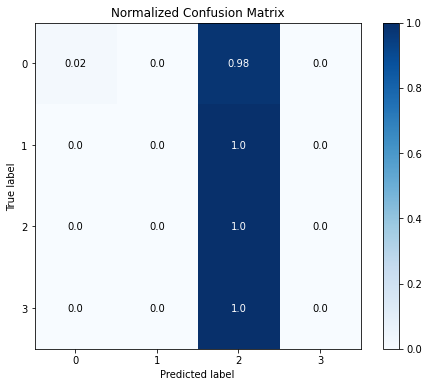

In [64]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

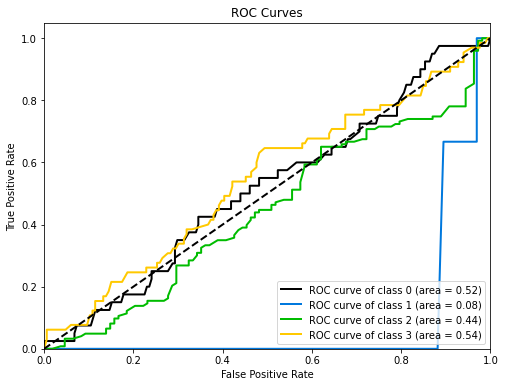

In [65]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

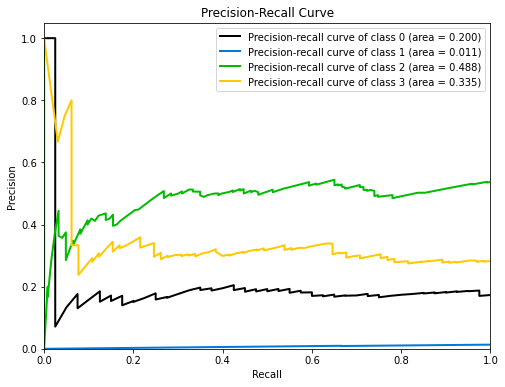

In [66]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

## 4. Multimodal Late Fusion

In [67]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True, nopain=False)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 1, 350, 35) (366, 4)
(231, 1, 350, 35) (231, 4)


In [68]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', nopain=False)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 1, 350, 25) (366, 4)
(231, 1, 350, 25) (231, 4)


In [69]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

Epoch 1/100
11/11 - 16s - loss: 1.4776 - accuracy: 0.4316 - auc_60: 0.7246 - precision_60: 0.0000e+00 - recall_60: 0.0000e+00 - f1_score: 0.2091 - val_loss: 1.2702 - val_accuracy: 0.4054 - val_auc_60: 0.7527 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1910 - 16s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 1.3680 - accuracy: 0.5319 - auc_60: 0.7944 - precision_60: 0.0000e+00 - recall_60: 0.0000e+00 - f1_score: 0.3235 - val_loss: 1.2707 - val_accuracy: 0.2973 - val_auc_60: 0.7111 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1644 - 3s/epoch - 239ms/step
Epoch 3/100
11/11 - 3s - loss: 1.2940 - accuracy: 0.5350 - auc_60: 0.7949 - precision_60: 0.8000 - recall_60: 0.0122 - f1_score: 0.4363 - val_loss: 1.2924 - val_accuracy: 0.3243 - val_auc_60: 0.7061 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1776 - 3s/epoch - 238ms/step
Epoch 4/100
11/11 - 3s - loss: 1.1578 - accuracy: 0.5866 - auc_60: 0.8

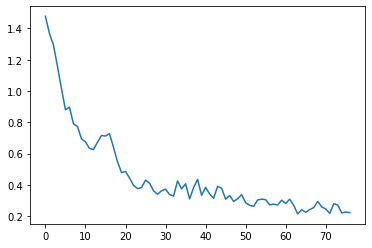

Epoch 1/100
11/11 - 17s - loss: 1.4251 - accuracy: 0.2340 - auc_61: 0.4912 - precision_61: 0.0000e+00 - recall_61: 0.0000e+00 - f1_score: 0.2095 - val_loss: 1.4091 - val_accuracy: 0.1622 - val_auc_61: 0.4967 - val_precision_61: 0.0000e+00 - val_recall_61: 0.0000e+00 - val_f1_score: 0.0698 - 17s/epoch - 2s/step
Epoch 2/100
11/11 - 3s - loss: 1.3615 - accuracy: 0.2918 - auc_61: 0.6852 - precision_61: 1.0000 - recall_61: 0.0091 - f1_score: 0.2243 - val_loss: 1.4112 - val_accuracy: 0.1622 - val_auc_61: 0.4126 - val_precision_61: 0.0000e+00 - val_recall_61: 0.0000e+00 - val_f1_score: 0.0698 - 3s/epoch - 235ms/step
Epoch 3/100
11/11 - 3s - loss: 1.2872 - accuracy: 0.4650 - auc_61: 0.7733 - precision_61: 0.8333 - recall_61: 0.0152 - f1_score: 0.3892 - val_loss: 1.4112 - val_accuracy: 0.1622 - val_auc_61: 0.4217 - val_precision_61: 0.5000 - val_recall_61: 0.0270 - val_f1_score: 0.0750 - 3s/epoch - 246ms/step
Epoch 4/100
11/11 - 3s - loss: 1.1108 - accuracy: 0.5380 - auc_61: 0.8052 - precision_

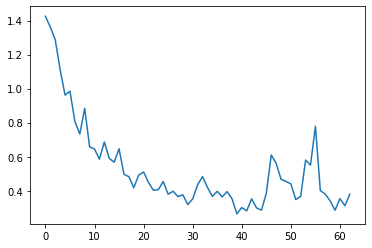

Epoch 1/100
11/11 - 15s - loss: 1.3587 - accuracy: 0.4438 - auc_62: 0.7420 - precision_62: 0.0000e+00 - recall_62: 0.0000e+00 - f1_score: 0.2493 - val_loss: 1.3415 - val_accuracy: 0.1351 - val_auc_62: 0.5050 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.0610 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 1.2755 - accuracy: 0.5046 - auc_62: 0.7663 - precision_62: 1.0000 - recall_62: 0.0030 - f1_score: 0.3332 - val_loss: 1.2943 - val_accuracy: 0.1892 - val_auc_62: 0.6418 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.0995 - 3s/epoch - 230ms/step
Epoch 3/100
11/11 - 3s - loss: 1.2229 - accuracy: 0.5380 - auc_62: 0.8156 - precision_62: 0.8571 - recall_62: 0.0182 - f1_score: 0.4033 - val_loss: 1.3171 - val_accuracy: 0.1351 - val_auc_62: 0.5579 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.0595 - 3s/epoch - 229ms/step
Epoch 4/100
11/11 - 2s - loss: 1.0960 - accuracy: 0.3708 - auc_62: 0.7091 - pr

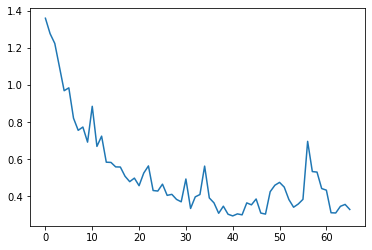

Epoch 1/100
11/11 - 15s - loss: 1.4714 - accuracy: 0.4438 - auc_63: 0.7248 - precision_63: 0.0000e+00 - recall_63: 0.0000e+00 - f1_score: 0.2374 - val_loss: 1.2698 - val_accuracy: 0.5946 - val_auc_63: 0.7793 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.1864 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 1.3673 - accuracy: 0.5562 - auc_63: 0.8091 - precision_63: 0.0000e+00 - recall_63: 0.0000e+00 - f1_score: 0.3123 - val_loss: 1.2993 - val_accuracy: 0.5676 - val_auc_63: 0.7267 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.1842 - 2s/epoch - 217ms/step
Epoch 3/100
11/11 - 2s - loss: 1.2688 - accuracy: 0.4954 - auc_63: 0.7908 - precision_63: 0.7500 - recall_63: 0.0182 - f1_score: 0.3777 - val_loss: 1.3041 - val_accuracy: 0.4595 - val_auc_63: 0.6961 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.1881 - 2s/epoch - 215ms/step
Epoch 4/100
11/11 - 2s - loss: 1.1640 - accuracy: 0.4377 - auc_63: 0.7

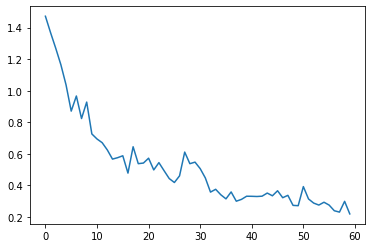

Epoch 1/100
11/11 - 15s - loss: 1.4356 - accuracy: 0.3191 - auc_64: 0.5729 - precision_64: 0.0000e+00 - recall_64: 0.0000e+00 - f1_score: 0.1989 - val_loss: 1.3196 - val_accuracy: 0.5135 - val_auc_64: 0.7557 - val_precision_64: 0.0000e+00 - val_recall_64: 0.0000e+00 - val_f1_score: 0.2122 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 1.3805 - accuracy: 0.3982 - auc_64: 0.7085 - precision_64: 0.8000 - recall_64: 0.0122 - f1_score: 0.3294 - val_loss: 1.3719 - val_accuracy: 0.0811 - val_auc_64: 0.5961 - val_precision_64: 0.0000e+00 - val_recall_64: 0.0000e+00 - val_f1_score: 0.0375 - 2s/epoch - 225ms/step
Epoch 3/100
11/11 - 2s - loss: 1.3014 - accuracy: 0.2888 - auc_64: 0.6566 - precision_64: 0.6364 - recall_64: 0.0213 - f1_score: 0.2240 - val_loss: 1.2680 - val_accuracy: 0.6486 - val_auc_64: 0.7710 - val_precision_64: 0.0000e+00 - val_recall_64: 0.0000e+00 - val_f1_score: 0.2069 - 2s/epoch - 223ms/step
Epoch 4/100
11/11 - 2s - loss: 1.2104 - accuracy: 0.5076 - auc_64: 0.7629 - pr

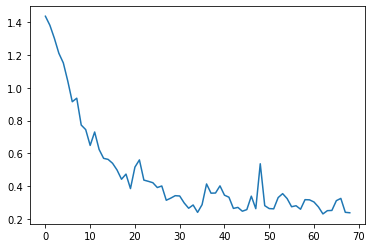

Epoch 1/100
11/11 - 15s - loss: 1.4534 - accuracy: 0.1398 - auc_65: 0.4009 - precision_65: 0.0000e+00 - recall_65: 0.0000e+00 - f1_score: 0.1183 - val_loss: 1.3234 - val_accuracy: 0.7027 - val_auc_65: 0.8750 - val_precision_65: 0.0000e+00 - val_recall_65: 0.0000e+00 - val_f1_score: 0.2097 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 1.3845 - accuracy: 0.3769 - auc_65: 0.6375 - precision_65: 0.0000e+00 - recall_65: 0.0000e+00 - f1_score: 0.2906 - val_loss: 1.3429 - val_accuracy: 0.0541 - val_auc_65: 0.5743 - val_precision_65: 0.0000e+00 - val_recall_65: 0.0000e+00 - val_f1_score: 0.0256 - 2s/epoch - 217ms/step
Epoch 3/100
11/11 - 2s - loss: 1.2862 - accuracy: 0.4103 - auc_65: 0.7164 - precision_65: 0.7500 - recall_65: 0.0182 - f1_score: 0.3132 - val_loss: 1.3019 - val_accuracy: 0.4595 - val_auc_65: 0.7133 - val_precision_65: 0.0000e+00 - val_recall_65: 0.0000e+00 - val_f1_score: 0.2932 - 2s/epoch - 219ms/step
Epoch 4/100
11/11 - 2s - loss: 1.0983 - accuracy: 0.4620 - auc_65: 0.7

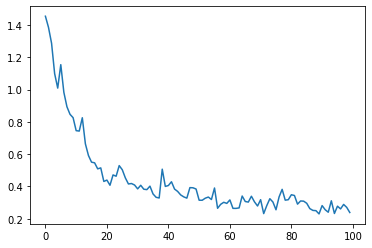

Epoch 1/100
11/11 - 16s - loss: 1.4452 - accuracy: 0.2758 - auc_66: 0.5895 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - f1_score: 0.1966 - val_loss: 1.2891 - val_accuracy: 0.7500 - val_auc_66: 0.8893 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.2964 - 16s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 1.3983 - accuracy: 0.5121 - auc_66: 0.7746 - precision_66: 1.0000 - recall_66: 0.0030 - f1_score: 0.3200 - val_loss: 1.2799 - val_accuracy: 0.6389 - val_auc_66: 0.8416 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.2695 - 3s/epoch - 249ms/step
Epoch 3/100
11/11 - 3s - loss: 1.2994 - accuracy: 0.3727 - auc_66: 0.7224 - precision_66: 0.8333 - recall_66: 0.0152 - f1_score: 0.3630 - val_loss: 1.4367 - val_accuracy: 0.0278 - val_auc_66: 0.3812 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.0714 - 3s/epoch - 245ms/step
Epoch 4/100
11/11 - 3s - loss: 1.1771 - accuracy: 0.3879 - auc_66: 0.7134 - pr

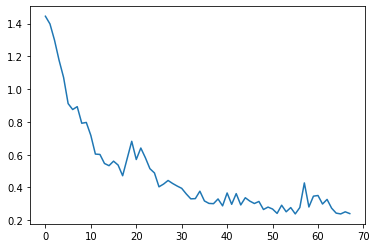

Epoch 1/100
11/11 - 15s - loss: 1.3754 - accuracy: 0.2152 - auc_67: 0.5543 - precision_67: 0.5000 - recall_67: 0.0030 - f1_score: 0.1518 - val_loss: 1.3449 - val_accuracy: 0.2222 - val_auc_67: 0.5606 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.0930 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 1.2713 - accuracy: 0.4091 - auc_67: 0.7288 - precision_67: 0.6667 - recall_67: 0.0061 - f1_score: 0.2876 - val_loss: 1.3099 - val_accuracy: 0.2222 - val_auc_67: 0.6789 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.0930 - 3s/epoch - 241ms/step
Epoch 3/100
11/11 - 3s - loss: 1.2364 - accuracy: 0.5030 - auc_67: 0.7788 - precision_67: 0.7143 - recall_67: 0.0152 - f1_score: 0.4602 - val_loss: 1.2615 - val_accuracy: 0.6667 - val_auc_67: 0.8441 - val_precision_67: 1.0000 - val_recall_67: 0.0556 - val_f1_score: 0.3667 - 3s/epoch - 254ms/step
Epoch 4/100
11/11 - 3s - loss: 1.1536 - accuracy: 0.5879 - auc_67: 0.8317 - precision_67: 0.71

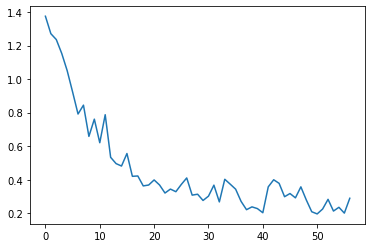

Epoch 1/100
11/11 - 15s - loss: 1.3275 - accuracy: 0.3333 - auc_68: 0.6070 - precision_68: 0.0000e+00 - recall_68: 0.0000e+00 - f1_score: 0.2028 - val_loss: 1.3221 - val_accuracy: 0.3333 - val_auc_68: 0.6988 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.1917 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 1.2901 - accuracy: 0.5000 - auc_68: 0.7640 - precision_68: 0.0000e+00 - recall_68: 0.0000e+00 - f1_score: 0.2883 - val_loss: 1.2912 - val_accuracy: 0.4722 - val_auc_68: 0.7562 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.2380 - 3s/epoch - 248ms/step
Epoch 3/100
11/11 - 3s - loss: 1.1555 - accuracy: 0.5697 - auc_68: 0.8260 - precision_68: 0.7143 - recall_68: 0.0152 - f1_score: 0.4582 - val_loss: 1.2489 - val_accuracy: 0.5833 - val_auc_68: 0.7769 - val_precision_68: 1.0000 - val_recall_68: 0.0278 - val_f1_score: 0.2443 - 3s/epoch - 244ms/step
Epoch 4/100
11/11 - 3s - loss: 1.0856 - accuracy: 0.4697 - auc_68: 0.7797 - pr

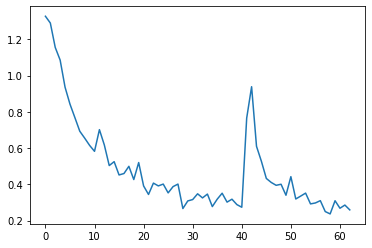

Epoch 1/100
11/11 - 14s - loss: 1.3510 - accuracy: 0.2455 - auc_69: 0.6783 - precision_69: 1.0000 - recall_69: 0.0030 - f1_score: 0.1368 - val_loss: 1.2728 - val_accuracy: 0.6389 - val_auc_69: 0.7937 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.1949 - 14s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 1.2790 - accuracy: 0.5455 - auc_69: 0.8024 - precision_69: 0.6667 - recall_69: 0.0121 - f1_score: 0.3104 - val_loss: 1.2972 - val_accuracy: 0.1667 - val_auc_69: 0.6285 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.0916 - 2s/epoch - 212ms/step
Epoch 3/100
11/11 - 2s - loss: 1.2187 - accuracy: 0.3909 - auc_69: 0.7352 - precision_69: 0.5833 - recall_69: 0.0212 - f1_score: 0.3659 - val_loss: 1.2801 - val_accuracy: 0.2222 - val_auc_69: 0.6528 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.1255 - 2s/epoch - 212ms/step
Epoch 4/100
11/11 - 2s - loss: 1.0789 - accuracy: 0.3939 - auc_69: 0.7623 - precision_

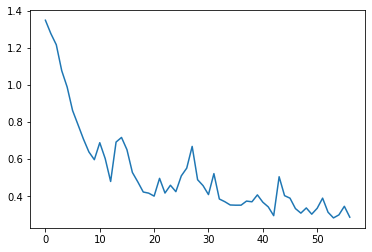

In [70]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_area_latefusion_model = CNNLSTM_fusioned(body_features, face_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_area_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_area_latefusion_model.save(model_path / 'late_area_cnnlstm.h5')

#### Training performance and variance

In [71]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.8494234085083008,
 'ROC/AUC': 0.9726478338241578,
 'Precision': 0.8537098646163941,
 'Recall': 0.8384958982467652,
 'F1-score': 0.7835053563117981}

In [72]:
late_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_cnnlstm_train_var

{'Accuracy': 0.0009632758409331643,
 'ROC/AUC': 0.00011773259504991528,
 'Precision': 0.0008722959965267307,
 'Recall': 0.0010224550590505997,
 'F1-score': 0.0017214067650415641}

#### Validation performance and variance

In [73]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.47837837040424347,
 'ROC/AUC': 0.7367253482341767,
 'Precision': 0.4881329745054245,
 'Recall': 0.4756756693124771,
 'F1-score': 0.3030925437808037}

In [74]:
late_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_cnnlstm_val_var

{'Accuracy': 0.008043381239834746,
 'ROC/AUC': 0.008291285595928635,
 'Precision': 0.009354630857578535,
 'Recall': 0.009234030622740877,
 'F1-score': 0.002893179269228165}

#### Performance and predictions on test set

In [75]:
cnnlstm_area_latefusion_model = load_model(model_path / 'late_area_cnnlstm.h5')
y_pred = cnnlstm_area_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_area_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 3s 73ms/step - loss: 1.2818 - accuracy: 0.4762 - auc_66: 0.7355 - precision_66: 0.4889 - recall_66: 0.3810 - f1_score: 0.2330
Accuracy: 47.62% 
ROC/AUC: 0.74 
Precision: 0.49 
Recall: 0.38 
F1 score: 0.23


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

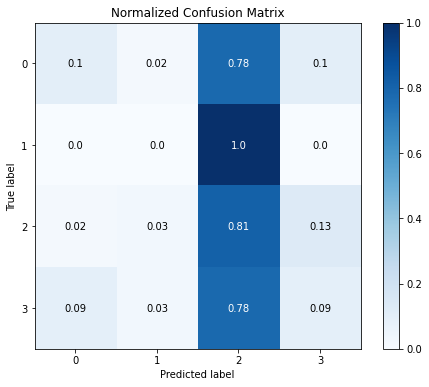

In [76]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

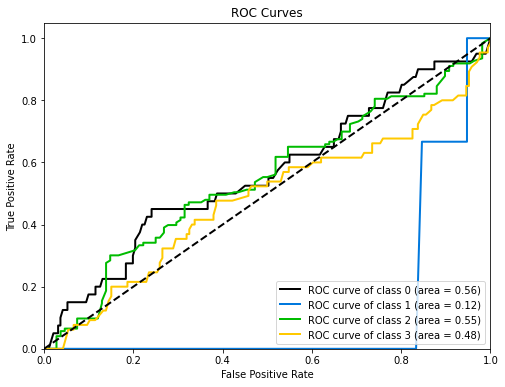

In [77]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

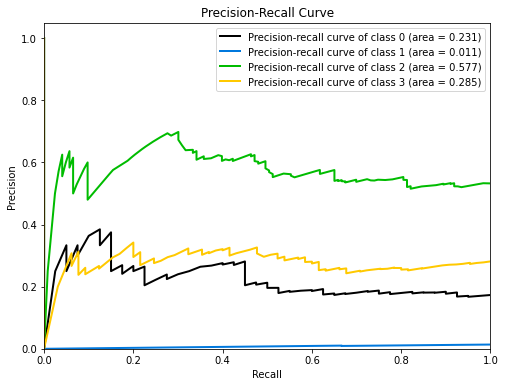

In [78]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 4.2 RCNN (Concatenation)

Epoch 1/100
11/11 - 4s - loss: 2.3867 - accuracy: 0.2736 - auc_70: 0.5342 - precision_70: 0.2741 - recall_70: 0.1641 - f1_score: 0.2051 - val_loss: 9.1117 - val_accuracy: 0.1622 - val_auc_70: 0.4575 - val_precision_70: 0.1622 - val_recall_70: 0.1622 - val_f1_score: 0.0698 - 4s/epoch - 387ms/step
Epoch 2/100
11/11 - 1s - loss: 1.5514 - accuracy: 0.3799 - auc_70: 0.6362 - precision_70: 0.4322 - recall_70: 0.3100 - f1_score: 0.3008 - val_loss: 13.9384 - val_accuracy: 0.2162 - val_auc_70: 0.4884 - val_precision_70: 0.2162 - val_recall_70: 0.2162 - val_f1_score: 0.0889 - 502ms/epoch - 46ms/step
Epoch 3/100
11/11 - 1s - loss: 1.5790 - accuracy: 0.4438 - auc_70: 0.7186 - precision_70: 0.4471 - recall_70: 0.3982 - f1_score: 0.4147 - val_loss: 2.3085 - val_accuracy: 0.3243 - val_auc_70: 0.6517 - val_precision_70: 0.3243 - val_recall_70: 0.3243 - val_f1_score: 0.2391 - 523ms/epoch - 48ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1246 - accuracy: 0.4863 - auc_70: 0.7900 - precision_70: 0.5174 - recal

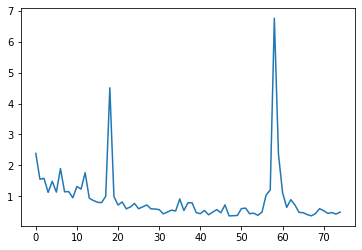

Epoch 1/100
11/11 - 4s - loss: 3.1468 - accuracy: 0.3313 - auc_71: 0.5785 - precision_71: 0.3273 - recall_71: 0.2736 - f1_score: 0.2270 - val_loss: 13.0343 - val_accuracy: 0.6486 - val_auc_71: 0.7658 - val_precision_71: 0.6486 - val_recall_71: 0.6486 - val_f1_score: 0.2608 - 4s/epoch - 387ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3898 - accuracy: 0.3708 - auc_71: 0.6527 - precision_71: 0.3960 - recall_71: 0.2432 - f1_score: 0.2869 - val_loss: 5.4787 - val_accuracy: 0.6216 - val_auc_71: 0.7636 - val_precision_71: 0.6216 - val_recall_71: 0.6216 - val_f1_score: 0.1917 - 540ms/epoch - 49ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2001 - accuracy: 0.4681 - auc_71: 0.7246 - precision_71: 0.5084 - recall_71: 0.3678 - f1_score: 0.3863 - val_loss: 1.8849 - val_accuracy: 0.6216 - val_auc_71: 0.8207 - val_precision_71: 0.6111 - val_recall_71: 0.5946 - val_f1_score: 0.2965 - 539ms/epoch - 49ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2818 - accuracy: 0.4894 - auc_71: 0.7654 - precision_71: 0.5128 - recal

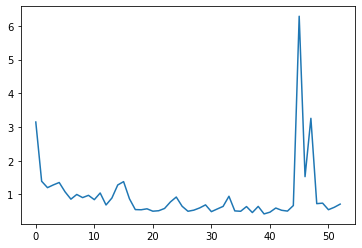

Epoch 1/100
11/11 - 4s - loss: 2.1321 - accuracy: 0.2249 - auc_72: 0.5336 - precision_72: 0.2317 - recall_72: 0.1824 - f1_score: 0.1845 - val_loss: 10.7771 - val_accuracy: 0.6486 - val_auc_72: 0.7678 - val_precision_72: 0.6486 - val_recall_72: 0.6486 - val_f1_score: 0.1967 - 4s/epoch - 390ms/step
Epoch 2/100
11/11 - 1s - loss: 1.7700 - accuracy: 0.3799 - auc_72: 0.6658 - precision_72: 0.4122 - recall_72: 0.3283 - f1_score: 0.2773 - val_loss: 45.5173 - val_accuracy: 0.1622 - val_auc_72: 0.4414 - val_precision_72: 0.1622 - val_recall_72: 0.1622 - val_f1_score: 0.0698 - 516ms/epoch - 47ms/step
Epoch 3/100
11/11 - 1s - loss: 1.6111 - accuracy: 0.3830 - auc_72: 0.6755 - precision_72: 0.3869 - recall_72: 0.3222 - f1_score: 0.3357 - val_loss: 10.2433 - val_accuracy: 0.6757 - val_auc_72: 0.7838 - val_precision_72: 0.6757 - val_recall_72: 0.6757 - val_f1_score: 0.2016 - 515ms/epoch - 47ms/step
Epoch 4/100
11/11 - 1s - loss: 1.4951 - accuracy: 0.5410 - auc_72: 0.7890 - precision_72: 0.5268 - rec

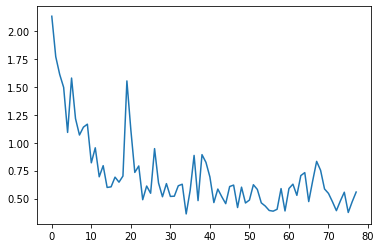

Epoch 1/100
11/11 - 4s - loss: 2.5215 - accuracy: 0.2979 - auc_73: 0.5763 - precision_73: 0.3223 - recall_73: 0.2675 - f1_score: 0.2352 - val_loss: 13.5283 - val_accuracy: 0.2432 - val_auc_73: 0.6379 - val_precision_73: 0.2432 - val_recall_73: 0.2432 - val_f1_score: 0.1233 - 4s/epoch - 387ms/step
Epoch 2/100
11/11 - 1s - loss: 1.6636 - accuracy: 0.3374 - auc_73: 0.6294 - precision_73: 0.3457 - recall_73: 0.2827 - f1_score: 0.2919 - val_loss: 18.3214 - val_accuracy: 0.0270 - val_auc_73: 0.3891 - val_precision_73: 0.0270 - val_recall_73: 0.0270 - val_f1_score: 0.0208 - 507ms/epoch - 46ms/step
Epoch 3/100
11/11 - 1s - loss: 1.8324 - accuracy: 0.3647 - auc_73: 0.6669 - precision_73: 0.3759 - recall_73: 0.3131 - f1_score: 0.2901 - val_loss: 6.3022 - val_accuracy: 0.5946 - val_auc_73: 0.7451 - val_precision_73: 0.5946 - val_recall_73: 0.5946 - val_f1_score: 0.1864 - 525ms/epoch - 48ms/step
Epoch 4/100
11/11 - 1s - loss: 1.4394 - accuracy: 0.4590 - auc_73: 0.7408 - precision_73: 0.4634 - reca

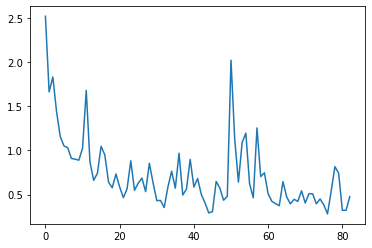

Epoch 1/100
11/11 - 4s - loss: 3.6436 - accuracy: 0.2310 - auc_74: 0.5421 - precision_74: 0.2374 - recall_74: 0.1854 - f1_score: 0.1927 - val_loss: 22.2197 - val_accuracy: 0.6486 - val_auc_74: 0.7658 - val_precision_74: 0.6486 - val_recall_74: 0.6486 - val_f1_score: 0.1967 - 4s/epoch - 389ms/step
Epoch 2/100
11/11 - 1s - loss: 1.9380 - accuracy: 0.4286 - auc_74: 0.6888 - precision_74: 0.4508 - recall_74: 0.3617 - f1_score: 0.3151 - val_loss: 11.2338 - val_accuracy: 0.0541 - val_auc_74: 0.4119 - val_precision_74: 0.0541 - val_recall_74: 0.0541 - val_f1_score: 0.0323 - 541ms/epoch - 49ms/step
Epoch 3/100
11/11 - 1s - loss: 1.7068 - accuracy: 0.3465 - auc_74: 0.6454 - precision_74: 0.3700 - recall_74: 0.3070 - f1_score: 0.2987 - val_loss: 17.4556 - val_accuracy: 0.6486 - val_auc_74: 0.7658 - val_precision_74: 0.6486 - val_recall_74: 0.6486 - val_f1_score: 0.1967 - 505ms/epoch - 46ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2312 - accuracy: 0.4985 - auc_74: 0.7654 - precision_74: 0.5090 - rec

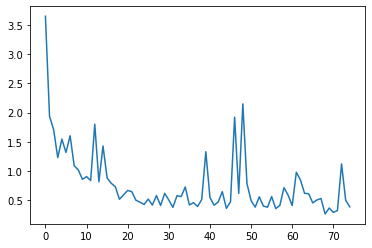

Epoch 1/100
11/11 - 4s - loss: 3.6785 - accuracy: 0.2158 - auc_75: 0.5174 - precision_75: 0.2140 - recall_75: 0.1672 - f1_score: 0.1651 - val_loss: 24.4602 - val_accuracy: 0.0270 - val_auc_75: 0.3606 - val_precision_75: 0.0270 - val_recall_75: 0.0270 - val_f1_score: 0.0132 - 4s/epoch - 391ms/step
Epoch 2/100
11/11 - 1s - loss: 1.5663 - accuracy: 0.2888 - auc_75: 0.6105 - precision_75: 0.2845 - recall_75: 0.2006 - f1_score: 0.2523 - val_loss: 3.7860 - val_accuracy: 0.5946 - val_auc_75: 0.7467 - val_precision_75: 0.5946 - val_recall_75: 0.5946 - val_f1_score: 0.1897 - 534ms/epoch - 49ms/step
Epoch 3/100
11/11 - 1s - loss: 1.4962 - accuracy: 0.4103 - auc_75: 0.7210 - precision_75: 0.4330 - recall_75: 0.3435 - f1_score: 0.3440 - val_loss: 20.3583 - val_accuracy: 0.0541 - val_auc_75: 0.3694 - val_precision_75: 0.0541 - val_recall_75: 0.0541 - val_f1_score: 0.0256 - 506ms/epoch - 46ms/step
Epoch 4/100
11/11 - 1s - loss: 1.3092 - accuracy: 0.4073 - auc_75: 0.7097 - precision_75: 0.4436 - reca

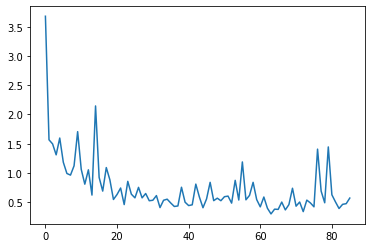

Epoch 1/100
11/11 - 4s - loss: 2.7466 - accuracy: 0.2848 - auc_76: 0.5551 - precision_76: 0.2868 - recall_76: 0.2242 - f1_score: 0.2172 - val_loss: 11.4616 - val_accuracy: 0.1111 - val_auc_76: 0.4588 - val_precision_76: 0.1111 - val_recall_76: 0.1111 - val_f1_score: 0.0500 - 4s/epoch - 392ms/step
Epoch 2/100
11/11 - 1s - loss: 1.5833 - accuracy: 0.3939 - auc_76: 0.6725 - precision_76: 0.4057 - recall_76: 0.3000 - f1_score: 0.3123 - val_loss: 4.6346 - val_accuracy: 0.6944 - val_auc_76: 0.8389 - val_precision_76: 0.6944 - val_recall_76: 0.6944 - val_f1_score: 0.2659 - 522ms/epoch - 47ms/step
Epoch 3/100
11/11 - 1s - loss: 1.6614 - accuracy: 0.3939 - auc_76: 0.6505 - precision_76: 0.3993 - recall_76: 0.3364 - f1_score: 0.3216 - val_loss: 32.2692 - val_accuracy: 0.1389 - val_auc_76: 0.4259 - val_precision_76: 0.1389 - val_recall_76: 0.1389 - val_f1_score: 0.0610 - 510ms/epoch - 46ms/step
Epoch 4/100
11/11 - 0s - loss: 1.4458 - accuracy: 0.4515 - auc_76: 0.7151 - precision_76: 0.4502 - reca

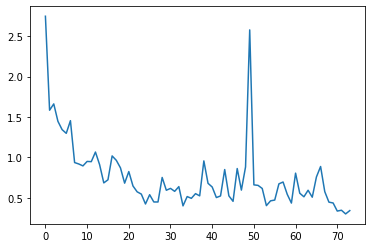

Epoch 1/100
11/11 - 4s - loss: 3.1282 - accuracy: 0.2879 - auc_77: 0.5650 - precision_77: 0.2973 - recall_77: 0.2333 - f1_score: 0.1993 - val_loss: 34.3901 - val_accuracy: 0.1389 - val_auc_77: 0.4259 - val_precision_77: 0.1389 - val_recall_77: 0.1389 - val_f1_score: 0.0610 - 4s/epoch - 387ms/step
Epoch 2/100
11/11 - 1s - loss: 2.0121 - accuracy: 0.3424 - auc_77: 0.6529 - precision_77: 0.3509 - recall_77: 0.2818 - f1_score: 0.2503 - val_loss: 20.2374 - val_accuracy: 0.1944 - val_auc_77: 0.4573 - val_precision_77: 0.1944 - val_recall_77: 0.1944 - val_f1_score: 0.0833 - 529ms/epoch - 48ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2333 - accuracy: 0.3636 - auc_77: 0.6752 - precision_77: 0.4018 - recall_77: 0.2727 - f1_score: 0.2994 - val_loss: 5.9795 - val_accuracy: 0.1667 - val_auc_77: 0.6083 - val_precision_77: 0.1667 - val_recall_77: 0.1667 - val_f1_score: 0.0714 - 534ms/epoch - 49ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0521 - accuracy: 0.4970 - auc_77: 0.7669 - precision_77: 0.5290 - reca

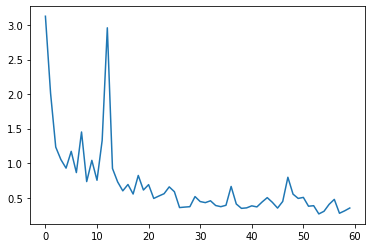

Epoch 1/100
11/11 - 4s - loss: 3.2042 - accuracy: 0.3091 - auc_78: 0.5782 - precision_78: 0.3227 - recall_78: 0.2455 - f1_score: 0.2231 - val_loss: 16.6653 - val_accuracy: 0.1389 - val_auc_78: 0.3954 - val_precision_78: 0.1389 - val_recall_78: 0.1389 - val_f1_score: 0.1515 - 4s/epoch - 389ms/step
Epoch 2/100
11/11 - 1s - loss: 1.3899 - accuracy: 0.3879 - auc_78: 0.6921 - precision_78: 0.3992 - recall_78: 0.2879 - f1_score: 0.2884 - val_loss: 15.0395 - val_accuracy: 0.2500 - val_auc_78: 0.4824 - val_precision_78: 0.2500 - val_recall_78: 0.2500 - val_f1_score: 0.1555 - 528ms/epoch - 48ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0435 - accuracy: 0.5061 - auc_78: 0.7663 - precision_78: 0.5133 - recall_78: 0.4091 - f1_score: 0.4155 - val_loss: 2.3778 - val_accuracy: 0.5278 - val_auc_78: 0.7665 - val_precision_78: 0.5143 - val_recall_78: 0.5000 - val_f1_score: 0.1759 - 527ms/epoch - 48ms/step
Epoch 4/100
11/11 - 1s - loss: 1.4767 - accuracy: 0.3939 - auc_78: 0.7039 - precision_78: 0.4167 - reca

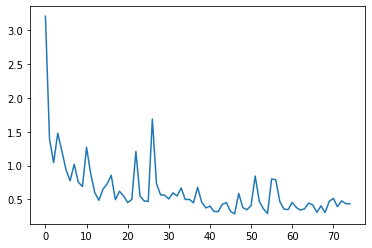

Epoch 1/100
11/11 - 4s - loss: 4.0176 - accuracy: 0.3242 - auc_79: 0.6099 - precision_79: 0.3198 - recall_79: 0.2152 - f1_score: 0.2379 - val_loss: 32.5277 - val_accuracy: 0.1667 - val_auc_79: 0.3971 - val_precision_79: 0.1667 - val_recall_79: 0.1667 - val_f1_score: 0.0750 - 4s/epoch - 384ms/step
Epoch 2/100
11/11 - 1s - loss: 1.2709 - accuracy: 0.4242 - auc_79: 0.6769 - precision_79: 0.4417 - recall_79: 0.2758 - f1_score: 0.3456 - val_loss: 20.4071 - val_accuracy: 0.1667 - val_auc_79: 0.4444 - val_precision_79: 0.1667 - val_recall_79: 0.1667 - val_f1_score: 0.0732 - 529ms/epoch - 48ms/step
Epoch 3/100
11/11 - 1s - loss: 0.9638 - accuracy: 0.5485 - auc_79: 0.7967 - precision_79: 0.5804 - recall_79: 0.4485 - f1_score: 0.4488 - val_loss: 18.5693 - val_accuracy: 0.1389 - val_auc_79: 0.4159 - val_precision_79: 0.1389 - val_recall_79: 0.1389 - val_f1_score: 0.0610 - 550ms/epoch - 50ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0999 - accuracy: 0.5152 - auc_79: 0.7716 - precision_79: 0.5455 - rec

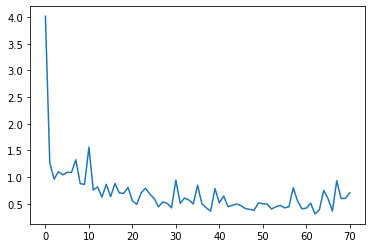

In [79]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_area_latefusion_model = RCNN_fusioned(body_features, face_features, n_length, n_outputs, multiclass=True)
    history = rcnn_area_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_area_latefusion_model.save(model_path / 'late_area_rcnn.h5')

#### Training performance and variance

In [80]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.8424297749996186,
 'ROC/AUC': 0.9511084854602814,
 'Precision': 0.8468212246894836,
 'Recall': 0.8369641780853272,
 'F1-score': 0.7573397994041443}

In [81]:
late_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_rcnn_train_var

{'Accuracy': 0.0012677192785922743,
 'ROC/AUC': 0.00021509823047569654,
 'Precision': 0.0010631489464708467,
 'Recall': 0.0013467774581476986,
 'F1-score': 0.0036790469612670053}

#### Validation performance and variance

In [82]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.4786036014556885,
 'ROC/AUC': 0.7073463022708892,
 'Precision': 0.4781652733683586,
 'Recall': 0.46223724633455276,
 'F1-score': 0.30620553344488144}

In [83]:
late_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_rcnn_val_var

{'Accuracy': 0.016492422132965957,
 'ROC/AUC': 0.008488807565558466,
 'Precision': 0.018868573834353253,
 'Recall': 0.01757771994279992,
 'F1-score': 0.008534371169855748}

#### Predictions and performance on test set

In [84]:
rcnn_area_latefusion_model = load_model(model_path / 'late_area_rcnn.h5')
y_pred = rcnn_area_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_area_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 14ms/step - loss: 2.1116 - accuracy: 0.4502 - auc_75: 0.7170 - precision_75: 0.4512 - recall_75: 0.4199 - f1_score: 0.2137
Accuracy: 45.02% 
ROC/AUC: 0.72 
Precision: 0.45 
Recall: 0.42 
F1 score: 0.21


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

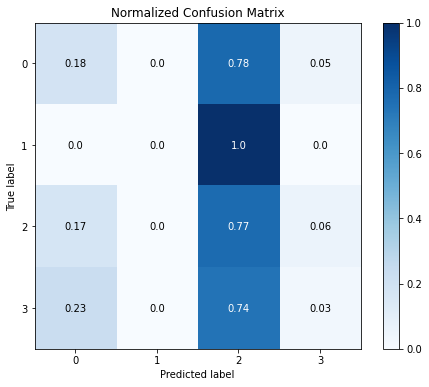

In [85]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

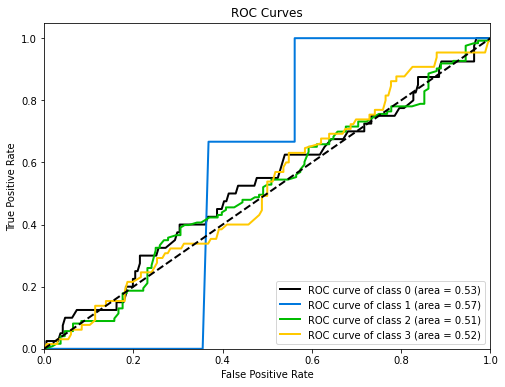

In [86]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

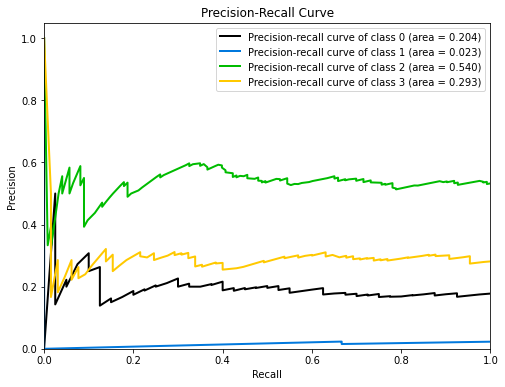

In [87]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, figsize=(8,6), plot_micro=False)

### 4.3 Ensemble

In [88]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_area_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_area_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_area_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_area_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [89]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [90]:
e = dirichletEnsemble.describe()
cnnlstm_auc.append(round(e, 2))
rcnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.0042)
RCNN Body Model (weight: 0.7804)
CNN + Bidirectional LSTM Face Model (weight: 0.0146)
RCNN Face Model (weight: 0.2008)
Accuracy: 54.98% - ROC/AUC: 0.47 - Precision: 0.48 - Recall: 0.28 - F1 score: 0.27


## Results

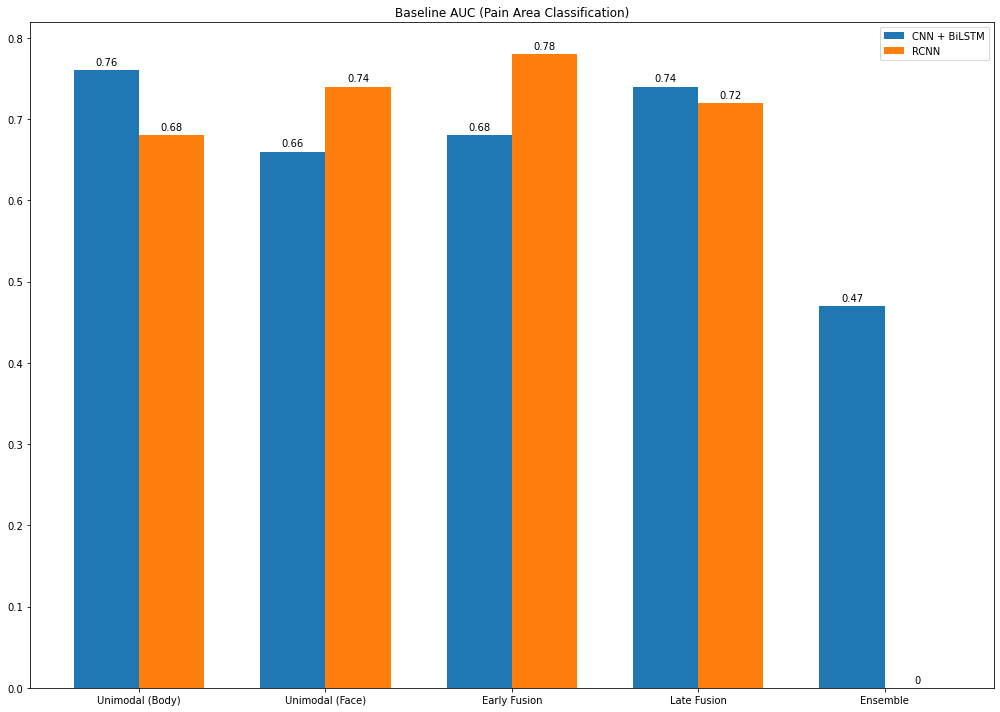

In [91]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rcnn_auc, width, label='RCNN')

ax.set_title('Baseline AUC (Pain Area Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()